# Fig 5 panels

In [1]:
import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

from tqdm.auto import tqdm
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from aging.plotting import (
    figure,
    format_plots,
    add_identity,
    legend,
    PlotConfig,
    save_factory,
)
from copy import deepcopy
from operator import or_
from toolz import reduce, valmap, keyfilter, pluck, dissoc
from aging.behavior.bio_age_model import fit_model, masked_xval, model_fun_v5, get_biological_age, compute_concentrations, concentration_interpolation, create_masks, expected_counts, compute_heldout_r2, model_setup, model_fun_v2
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA

In [2]:
format_plots()
c = PlotConfig()
# saver = save_factory(c.save_path / "fig-5", tight_layout=False)

In [3]:
def zscore(ser: pd.Series):
    return (ser - ser.mean()) / ser.std()


def demean(ser: pd.Series):
    return ser - ser.mean()


def quantile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'q_{:0.02f}'.format(n)
    return percentile_

In [4]:
to_remove = [
    "e4f1076b",
    "3867c517",
    "60e82cb4",
]

In [5]:
def load_long_df(n_bins: "Optional[int]" = 75):
    keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_males_raw_counts_matrix_v00.parquet"
    )
    df = df[keep_syllables]
    mask = df.index.get_level_values("age") < 100
    df = df[mask].copy()

    masks = []
    for uuid in to_remove:
        m = df.reset_index()['uuid'].str.startswith(uuid)
        masks.append(m)
    mask = np.array(reduce(or_, masks), dtype=bool)
    df = df[~mask].copy()

    size_df = pd.read_parquet(
        '/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_males_mouse_area_df_v00.parquet'
    )
    mask = size_df.index.get_level_values("age") < 100
    size_df = size_df[mask].copy()
    age_cut = pd.cut(size_df.index.get_level_values('age'), 19)

    size_df.loc[size_df['quant_0.5'] == 0, 'quant_0.5'] = np.nan
    sizes_col = size_df['quant_0.5']
    sizes_col = sizes_col.groupby('mouse').apply(lambda df: df.sort_index(level='age').interpolate()).droplevel(0)

    sizes_col = zscore(sizes_col.groupby(age_cut, observed=True).transform(demean))
    sizes_col = sizes_col.fillna(0)
    sizes_col = sizes_col.loc[df.index]

    # make sure df matches sizes
    df = df.loc[sizes_col.index]

    if n_bins is not None:
        # subsample the dataset
        cut, bins = pd.cut(df.index.get_level_values('age'), n_bins, retbins=True)
        # tmp_df = df.groupby(['mouse', cut], observed=True).first()
        tmp_df = df.reset_index().groupby(['mouse', cut], observed=True).first().reset_index().drop(columns=['level_1']).set_index(['age', 'mouse', 'subject_name', "session_name", 'uuid', 'date'])
        # mid_age = [round(v.left, 2) for v in tmp_df.index.get_level_values(1)]
        # tmp_df['age'] = mid_age
        # tmp_df = tmp_df.set_index('age', append=True).droplevel(1)

        sizes_col = sizes_col.reset_index().groupby(['mouse', cut], observed=True).first()
        sizes_col = sizes_col.reset_index().drop(columns=['level_1']).set_index(['age', 'mouse', 'subject_name', "session_name", 'uuid', 'date'])
        sizes_col = sizes_col.loc[tmp_df.index, 'quant_0.5']
    else:
        tmp_df = df

    age = jnp.array(tmp_df.index.get_level_values("age"))
    syllable_counts_jax = jnp.array(tmp_df.astype(float))

    label_encoder = OneHotEncoder(sparse_output=False, dtype=np.float32)
    mouse_ids = label_encoder.fit_transform(
        sizes_col.index.get_level_values("mouse").to_numpy()[:, None]
    ).T

    sort_idx = np.argsort(syllable_counts_jax.sum(0))[::-1]

    return tmp_df, syllable_counts_jax, age, sizes_col, mouse_ids, sort_idx

In [8]:
tmp_df, syllable_counts_jax, age, sizes_col, mouse_ids, sort_idx = load_long_df(75)

In [20]:
features = {
    "ages": age,  # models >= 1
    "counts": syllable_counts_jax + 1,  # models >= 1
    "sizes": sizes_col.to_numpy(),  # models > 1
    "mice": mouse_ids,  # models > 2
}

hypparams = {
    "min_age": 1,
    # "max_age": 100,
    "max_age": 120,
    "age_sd": 9,  # weeks
    "n_age_samples": 504,
    "n_splines": 4,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_development_splines": 5,
    "scale": 150,
    "normalize_by_softmax": True,
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "n_animals": len(mouse_ids),
    "lr": 0.2,
    "n_opt_iter": 350,
}

In [21]:
mdl = fit_model(features, hypparams, 5)

In [34]:
pca = PCA(n_components=3)
scores = pca.fit_transform(tmp_df)

scores_df = pd.DataFrame(scores, index=tmp_df.index)

age_np = pd.Series(np.array(age))
age_cuts = pd.qcut(age_np, q=30, labels=False)
bio_age_map = pd.qcut(mdl['bio_ages'], q=30, labels=False)

scores_df['age_cut'] = age_cuts.to_numpy()
scores_df = scores_df.set_index('age_cut', append=True)

scores_df['bio_age'] = bio_age_map
scores_df = scores_df.set_index('bio_age', append=True)

avgs = scores_df.groupby('age_cut').mean()
bio_avgs = scores_df.groupby('bio_age').mean()

In [36]:
norm = plt.Normalize(vmin=avgs.index.min(), vmax=avgs.index.max())
cmap = plt.colormaps['viridis']
norm2 = plt.Normalize(vmin=bio_avgs.index.min(), vmax=bio_avgs.index.max())
cmap2 = plt.colormaps['inferno']
cmap3 = plt.colormaps['turbo']
cmap4 = plt.colormaps['twilight_r']

In [37]:
from toolz import sliding_window

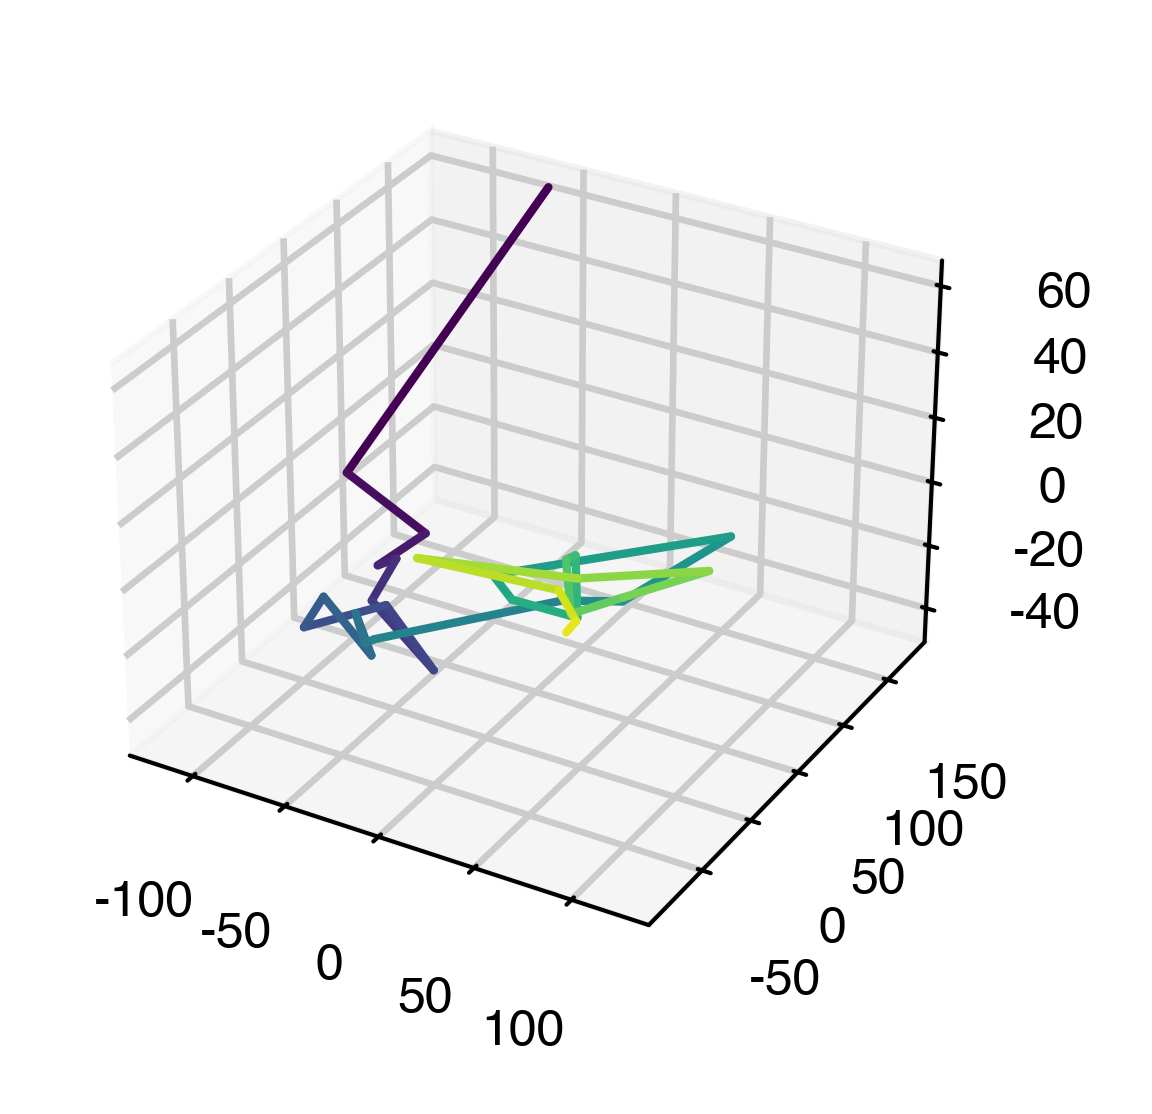

In [38]:
fig = figure(2, 2)
ax = fig.add_subplot(111, projection='3d')
for (_age1, _df1), (_age2, _df2) in sliding_window(2, avgs.iterrows()):
    ax.plot([_df1[0], _df2[0]], [_df1[1], _df2[1]], [_df1[2], _df2[2]], color=cmap(norm(_age1)))
# for (_age1, _df1), (_age2, _df2) in sliding_window(2, bio_avgs.iterrows()):
#     ax.plot([_df1[0], _df2[0]], [_df1[1], _df2[1]], [_df1[2], _df2[2]], color=cmap2(norm2(_age1)))

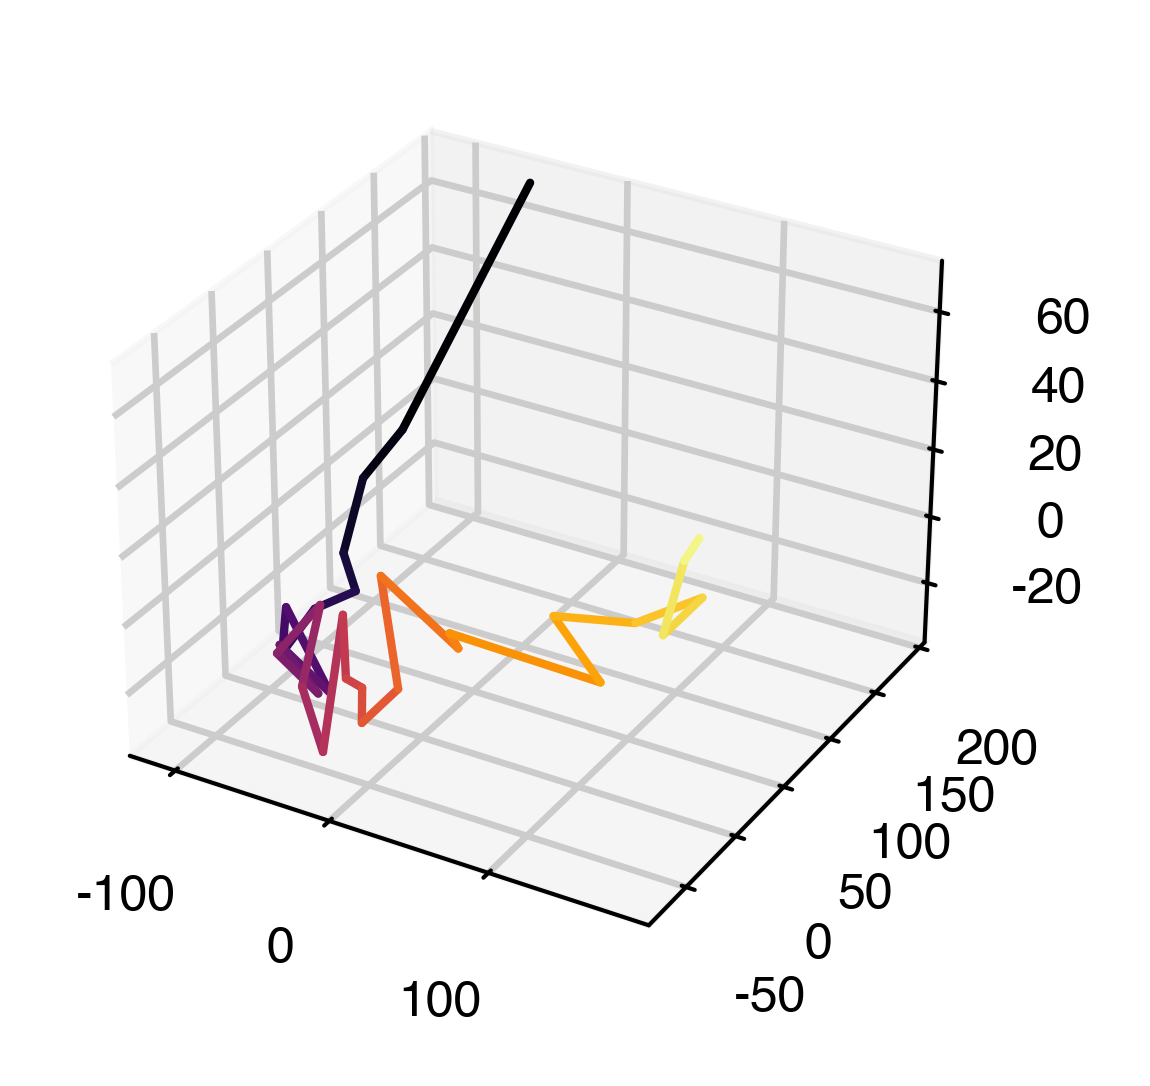

In [39]:
fig = figure(2, 2)
ax = fig.add_subplot(111, projection='3d')
# for (_age1, _df1), (_age2, _df2) in sliding_window(2, avgs.iterrows()):
#     ax.plot([_df1[0], _df2[0]], [_df1[1], _df2[1]], [_df1[2], _df2[2]], color=cmap(norm(_age1)))
for (_age1, _df1), (_age2, _df2) in sliding_window(2, bio_avgs.iterrows()):
    ax.plot([_df1[0], _df2[0]], [_df1[1], _df2[1]], [_df1[2], _df2[2]], color=cmap2(norm2(_age1)))
# for (_age1, _df1), (_age2, _df2) in sliding_window(2, bio_pred_avgs.iterrows()):
#     plt.plot([_df1[0], _df2[0]], [_df1[1], _df2[1]], color=cmap3(norm(_age1)))
# for (_age1, _df1), (_age2, _df2) in sliding_window(2, bio_pred_avgs_bio.iterrows()):
#     plt.plot([_df1[0], _df2[0]], [_df1[1], _df2[1]], color=cmap4(norm2(_age1)))

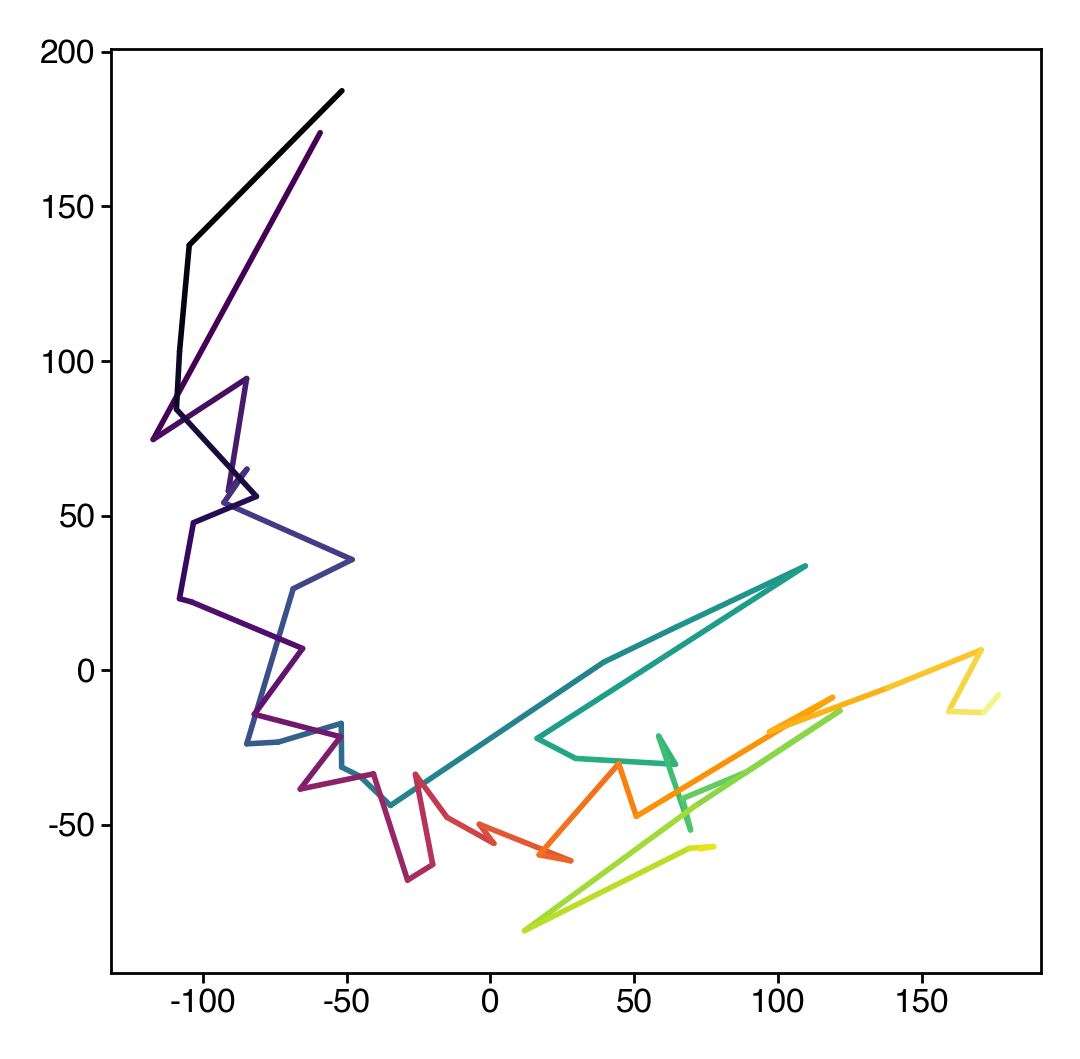

In [40]:
for (_age1, _df1), (_age2, _df2) in sliding_window(2, avgs.iterrows()):
    plt.plot([_df1[0], _df2[0]], [_df1[1], _df2[1]], color=cmap(norm(_age1)))
for (_age1, _df1), (_age2, _df2) in sliding_window(2, bio_avgs.iterrows()):
    plt.plot([_df1[0], _df2[0]], [_df1[1], _df2[1]], color=cmap2(norm2(_age1)))

In [43]:
avgs = scores_df.groupby(['mouse', 'age_cut']).mean()
bio_avgs = scores_df.groupby(['mouse', 'bio_age']).mean()

In [45]:
avgs

0           1          2
mouse age_cut                                   
01_01 0        -60.849016  181.629889  24.284190
      1       -106.676479  128.521793 -70.843733
      2       -111.876458  152.885360 -39.208346
      3        -99.218090   66.474300 -56.265219
      4       -101.568858   60.422084 -53.701381
...                   ...         ...        ...
04_04 25        -5.201060  -17.882669   8.707529
      26       -88.391055  -76.465793  12.594875
      27       -24.627987  -45.411550   0.612303
      28       -23.453399  -38.743321  -9.600904
      29        30.811713    4.616292 -55.341796

[460 rows x 3 columns]

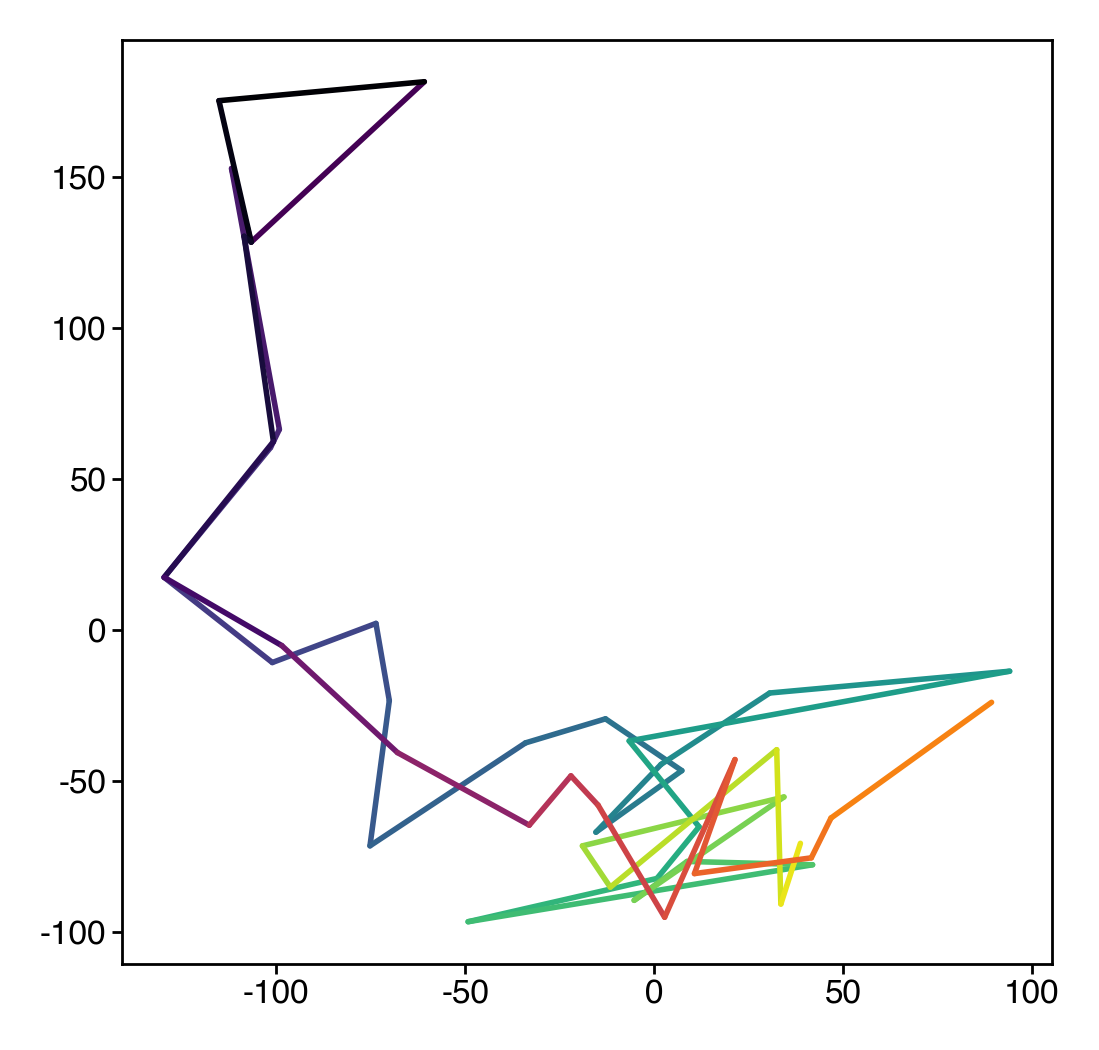

In [46]:
for (_age1, _df1), (_age2, _df2) in sliding_window(2, avgs.loc['01_01'].iterrows()):
    plt.plot([_df1[0], _df2[0]], [_df1[1], _df2[1]], color=cmap(norm(_age1)))
for (_age1, _df1), (_age2, _df2) in sliding_window(2, bio_avgs.loc['01_01'].iterrows()):
    plt.plot([_df1[0], _df2[0]], [_df1[1], _df2[1]], color=cmap2(norm2(_age1)))

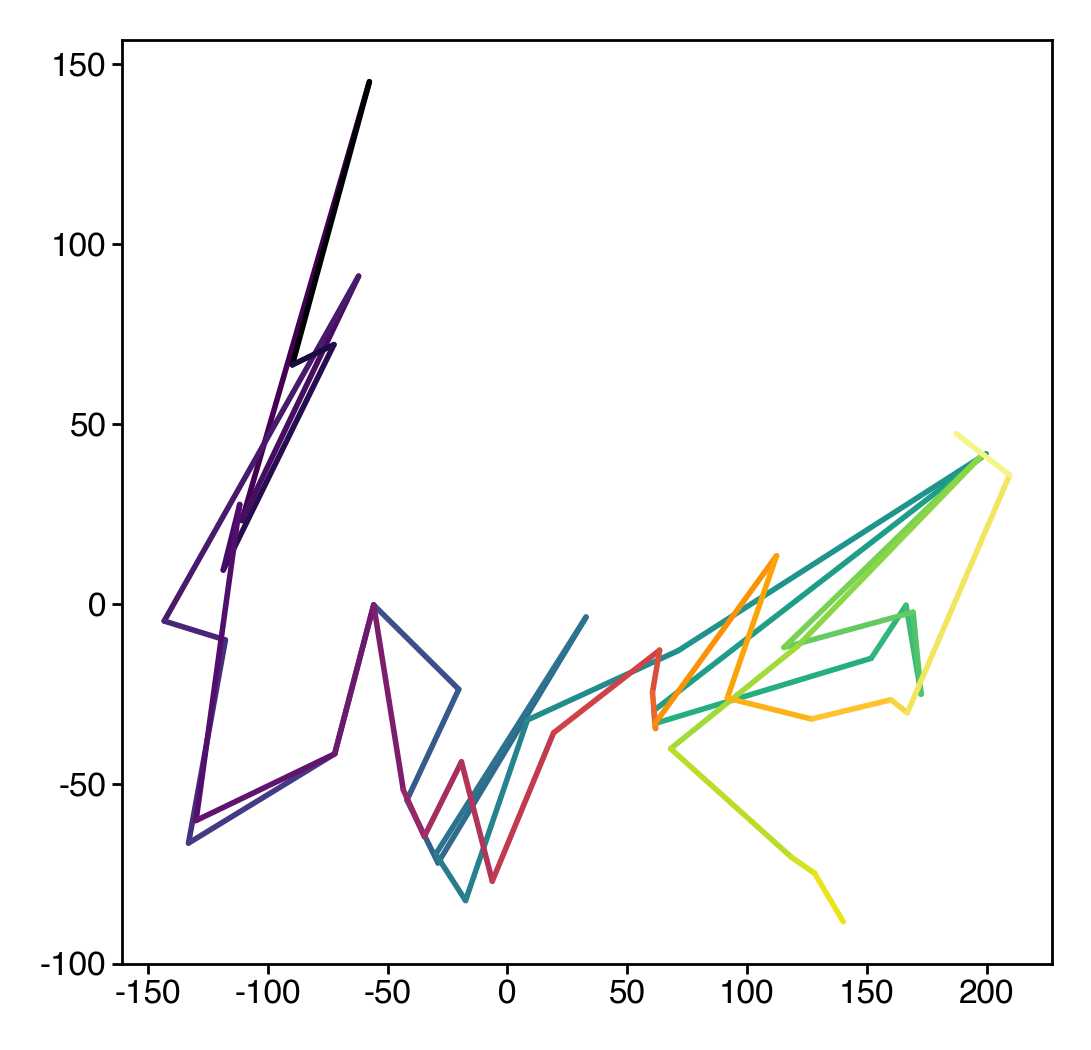

In [47]:
for (_age1, _df1), (_age2, _df2) in sliding_window(2, avgs.loc['01_02'].iterrows()):
    plt.plot([_df1[0], _df2[0]], [_df1[1], _df2[1]], color=cmap(norm(_age1)))
for (_age1, _df1), (_age2, _df2) in sliding_window(2, bio_avgs.loc['01_02'].iterrows()):
    plt.plot([_df1[0], _df2[0]], [_df1[1], _df2[1]], color=cmap2(norm2(_age1)))

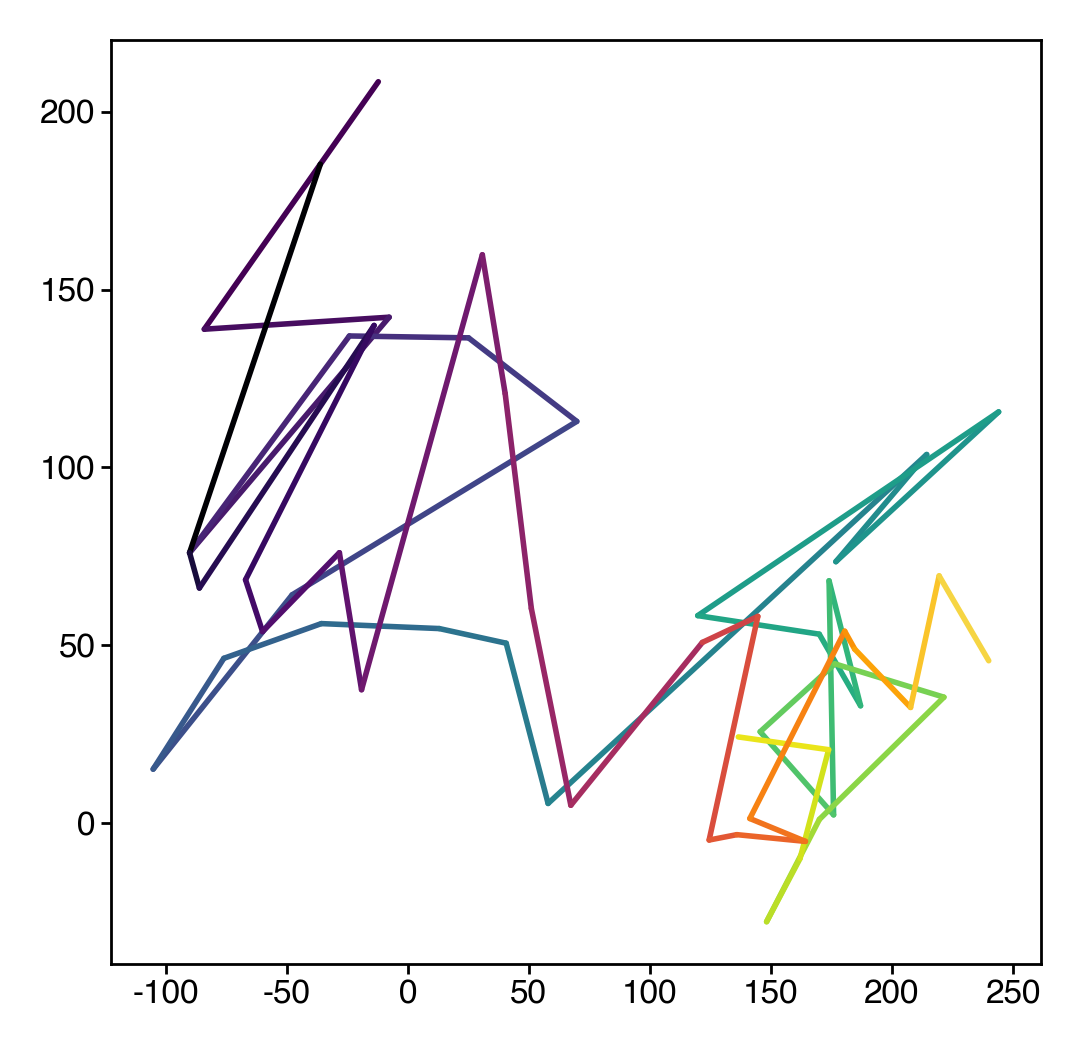

In [48]:
for (_age1, _df1), (_age2, _df2) in sliding_window(2, avgs.loc['02_01'].iterrows()):
    plt.plot([_df1[0], _df2[0]], [_df1[1], _df2[1]], color=cmap(norm(_age1)))
for (_age1, _df1), (_age2, _df2) in sliding_window(2, bio_avgs.loc['02_01'].iterrows()):
    plt.plot([_df1[0], _df2[0]], [_df1[1], _df2[1]], color=cmap2(norm2(_age1)))

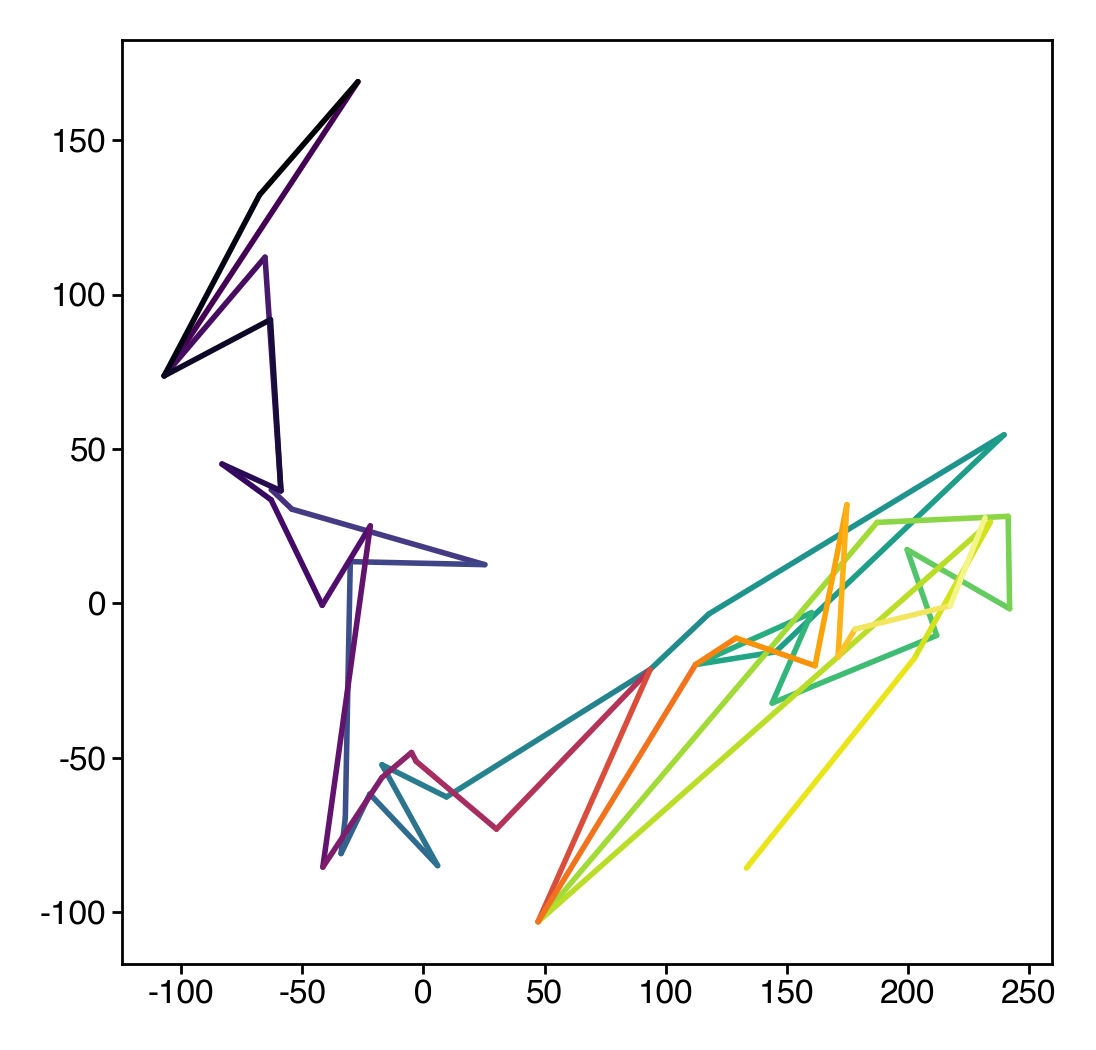

In [49]:
for (_age1, _df1), (_age2, _df2) in sliding_window(2, avgs.loc['02_02'].iterrows()):
    plt.plot([_df1[0], _df2[0]], [_df1[1], _df2[1]], color=cmap(norm(_age1)))
for (_age1, _df1), (_age2, _df2) in sliding_window(2, bio_avgs.loc['02_02'].iterrows()):
    plt.plot([_df1[0], _df2[0]], [_df1[1], _df2[1]], color=cmap2(norm2(_age1)))

In [50]:
from sklearn.decomposition import NMF

In [69]:
nmf = NMF(n_components=4, random_state=0, max_iter=2_000)
scores = nmf.fit_transform(tmp_df)

In [70]:
nmf_scores_df = pd.DataFrame(scores, tmp_df.index)
nmf_scores_df['age_cut'] = age_cuts.to_numpy()
nmf_scores_df['bio_age_cut'] = bio_age_map
nmf_scores_df = nmf_scores_df.set_index('age_cut', append=True)
nmf_scores_df = nmf_scores_df.set_index('bio_age_cut', append=True)

<Axes: xlabel='age_cut'>

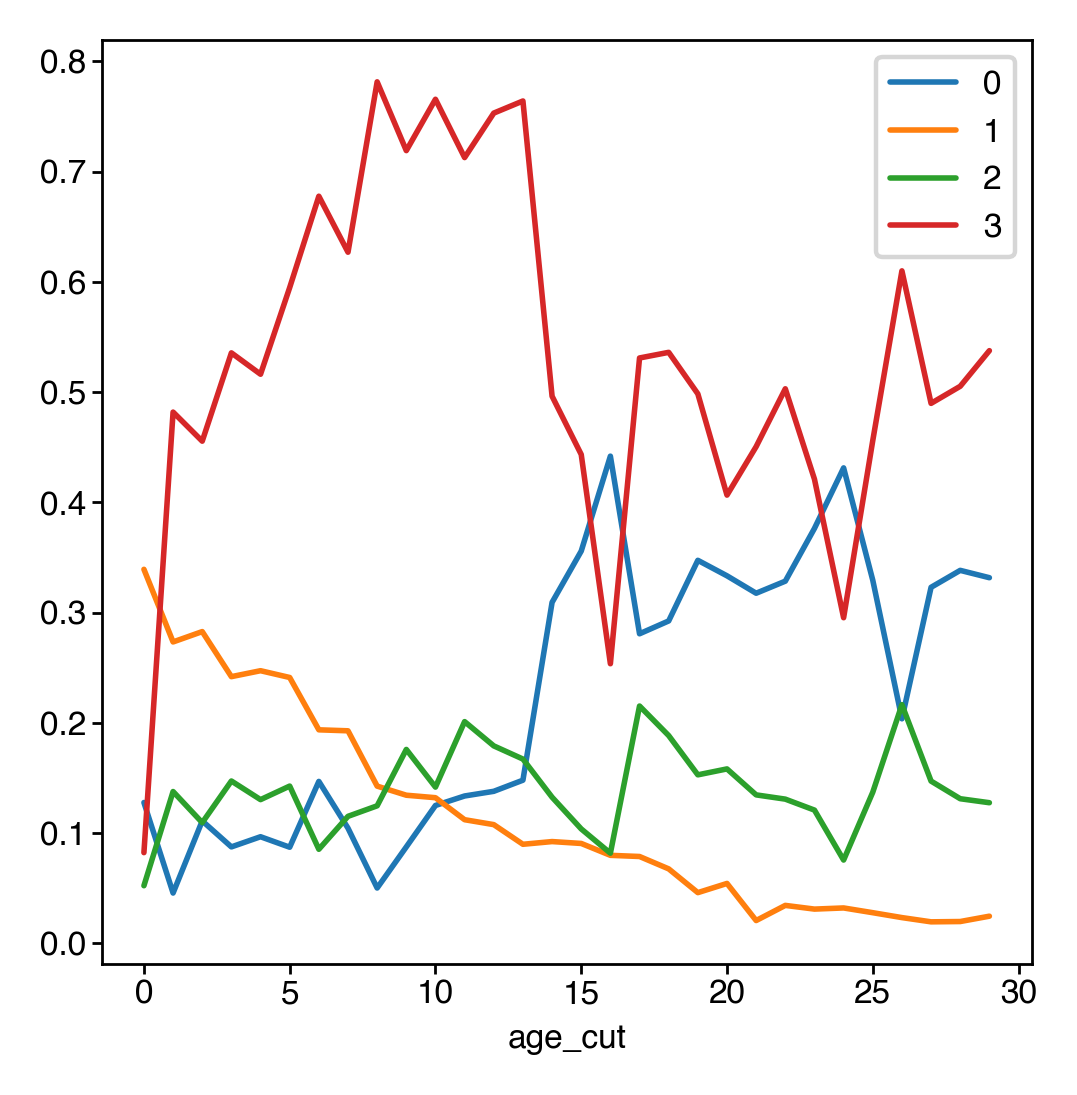

In [71]:
nmf_scores_df.groupby('age_cut').mean().plot()

<Axes: xlabel='bio_age_cut'>

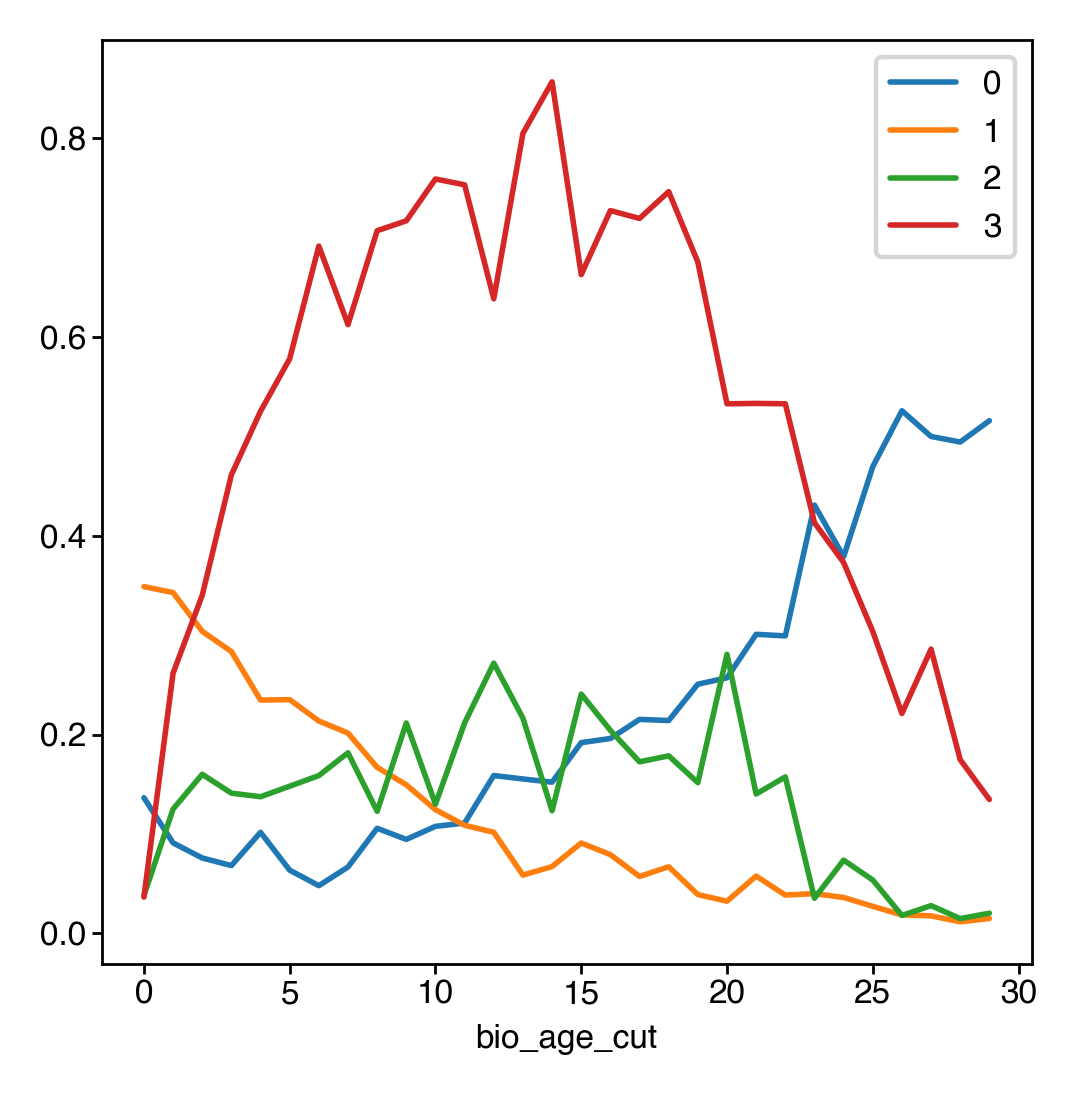

In [72]:
nmf_scores_df.groupby('bio_age_cut').mean().plot()

In [85]:
filt_df = nmf_scores_df.query('age_cut > 5 & age_cut < 15').reset_index()

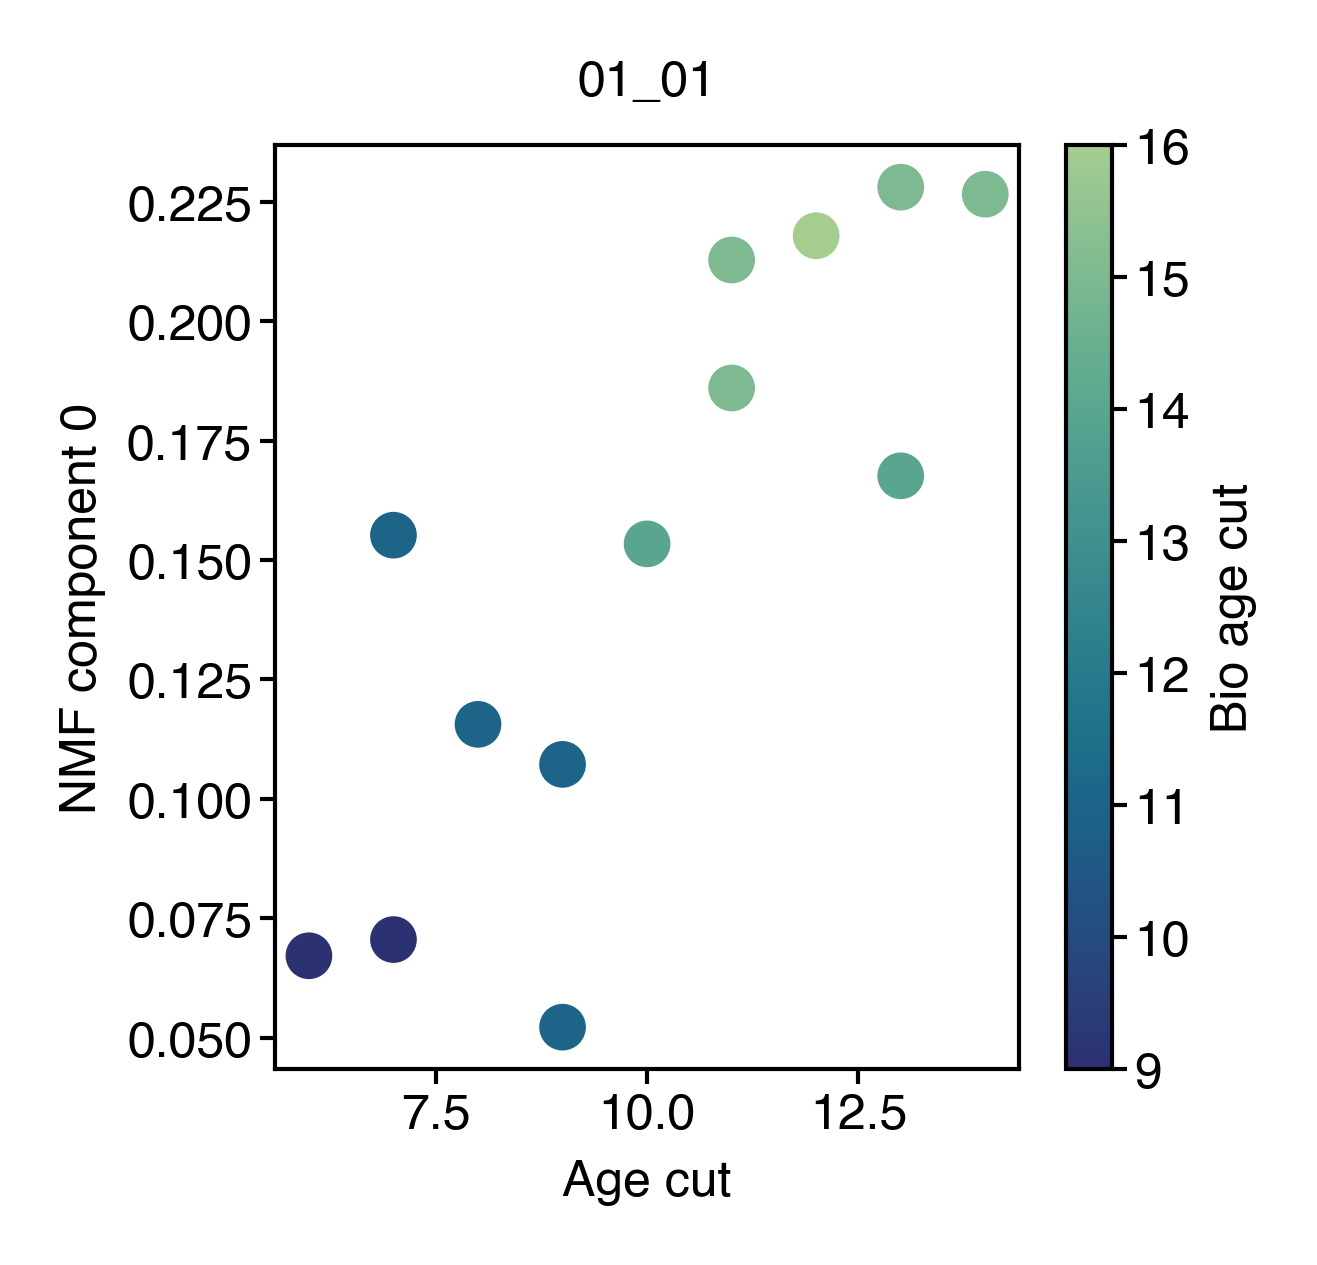

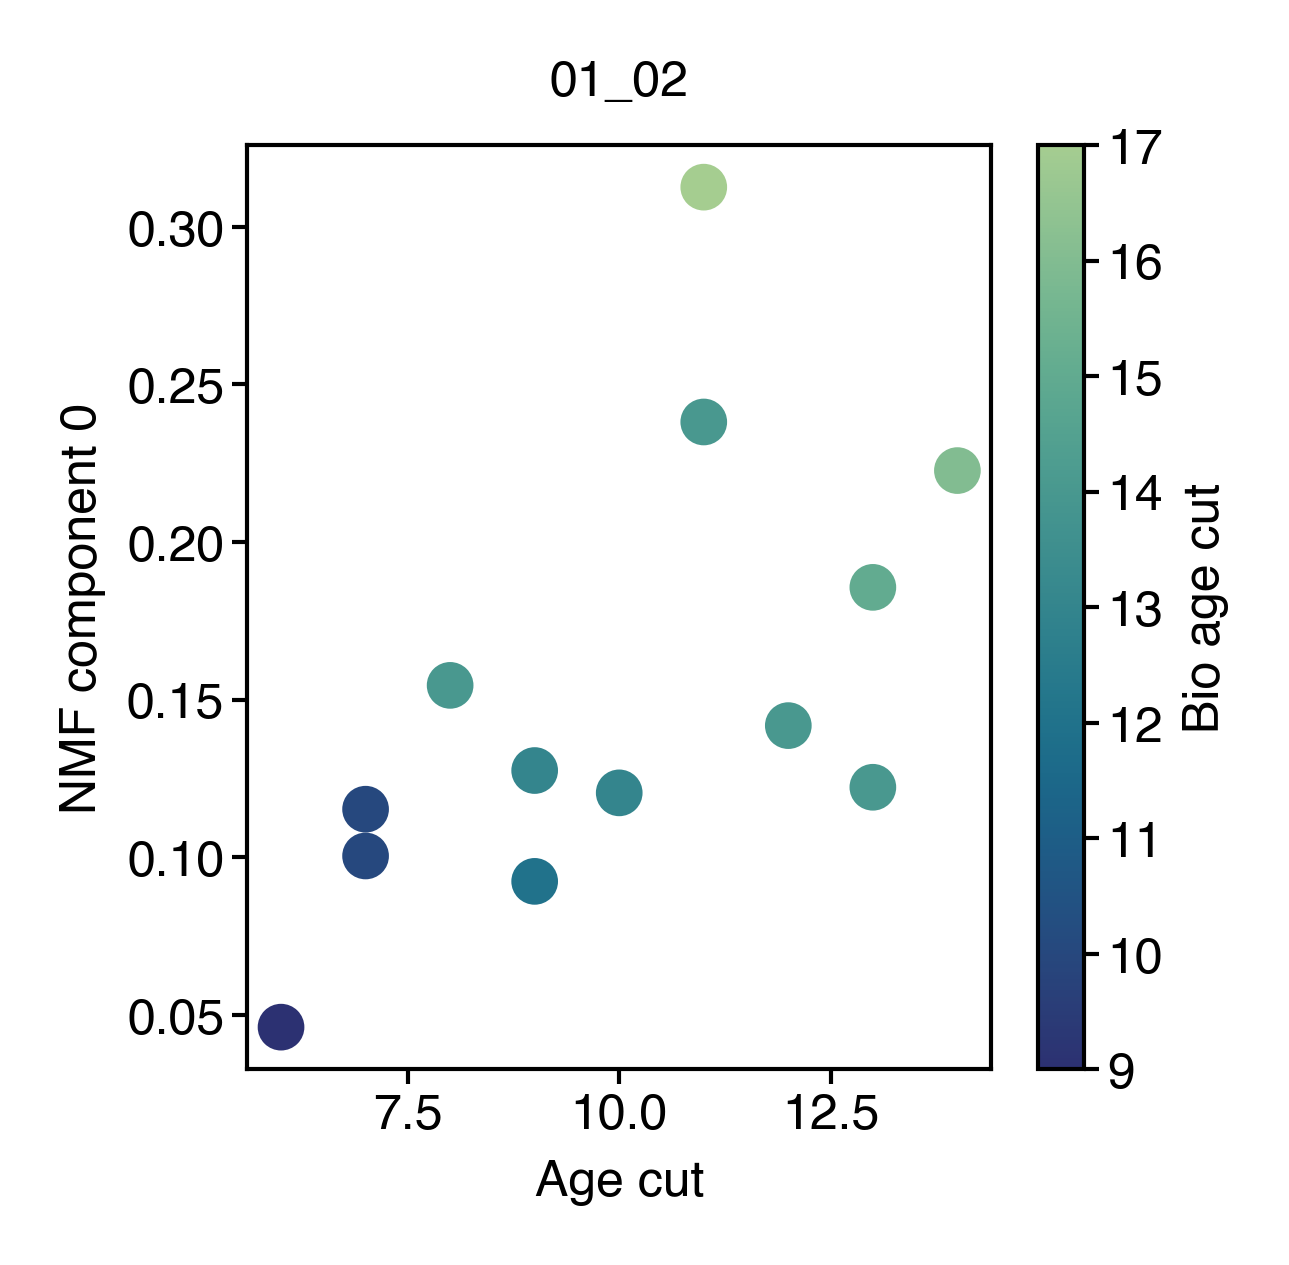

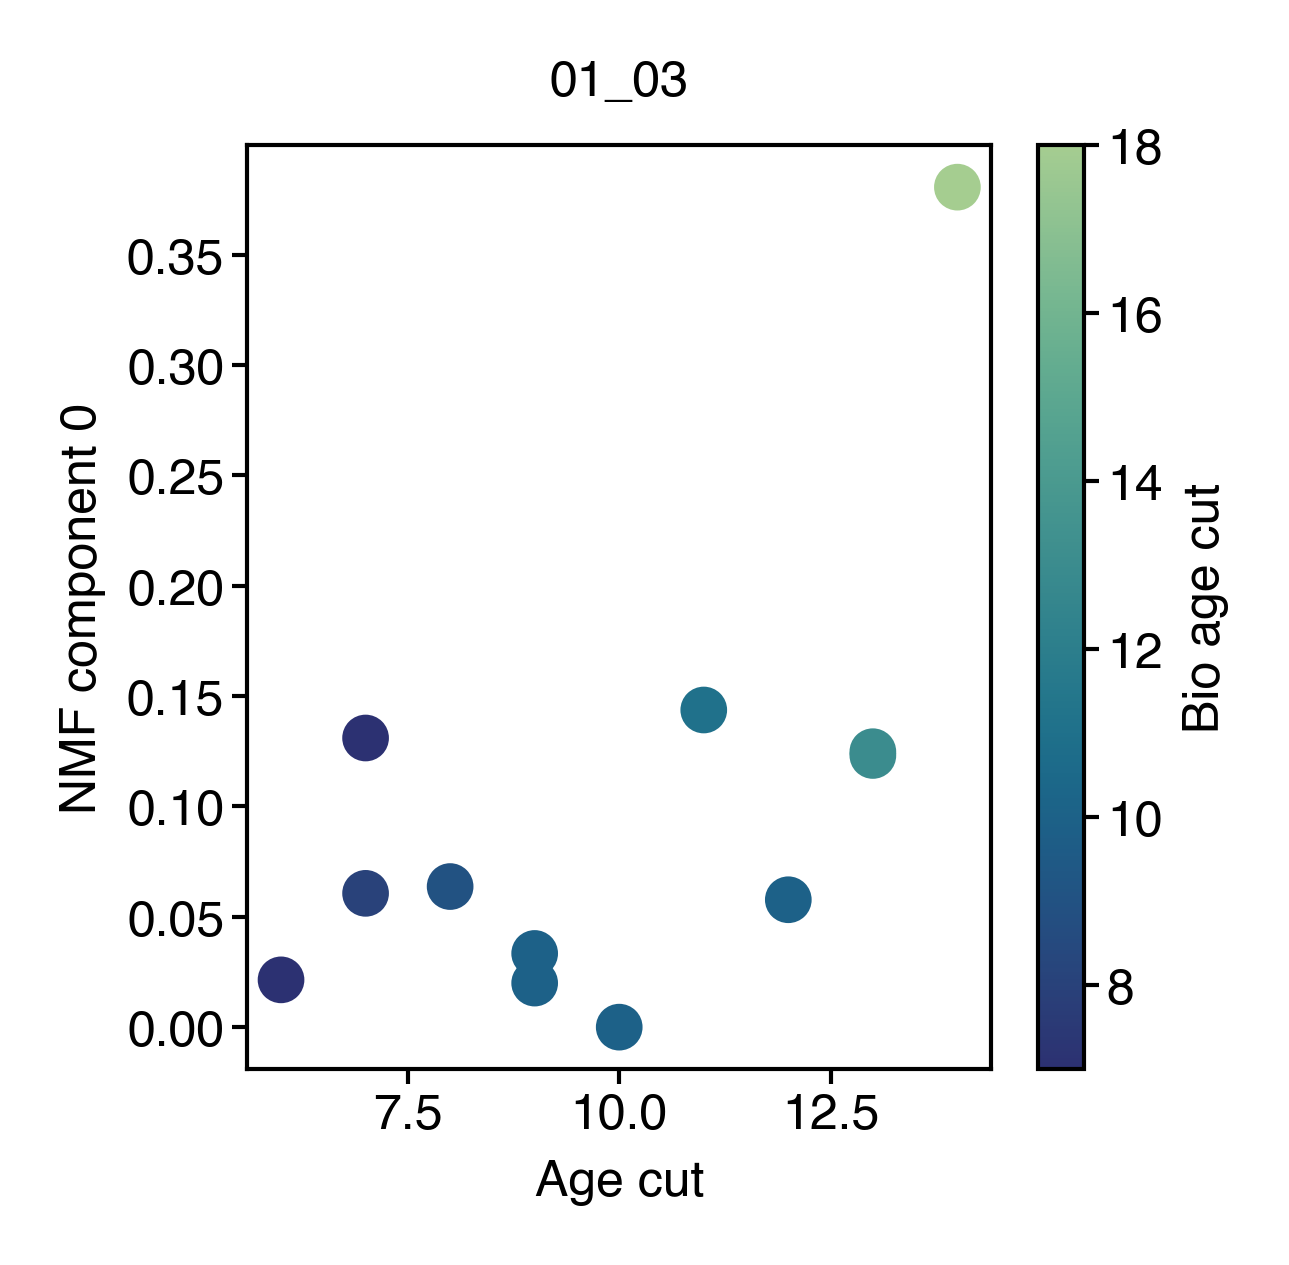

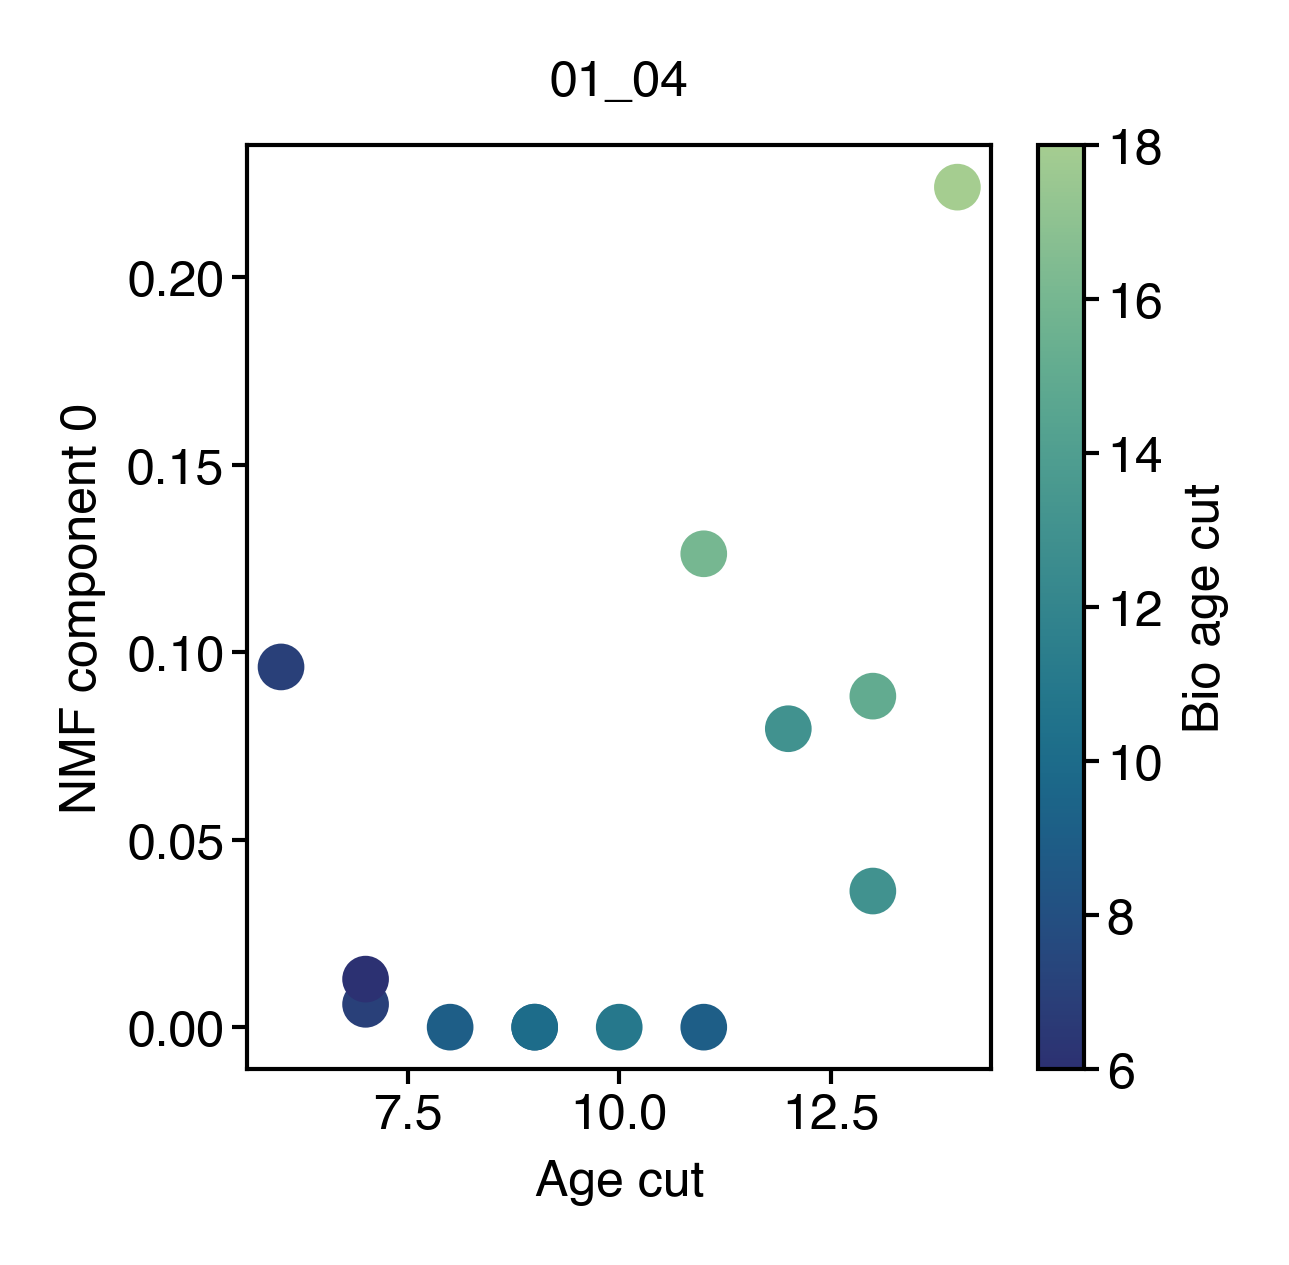

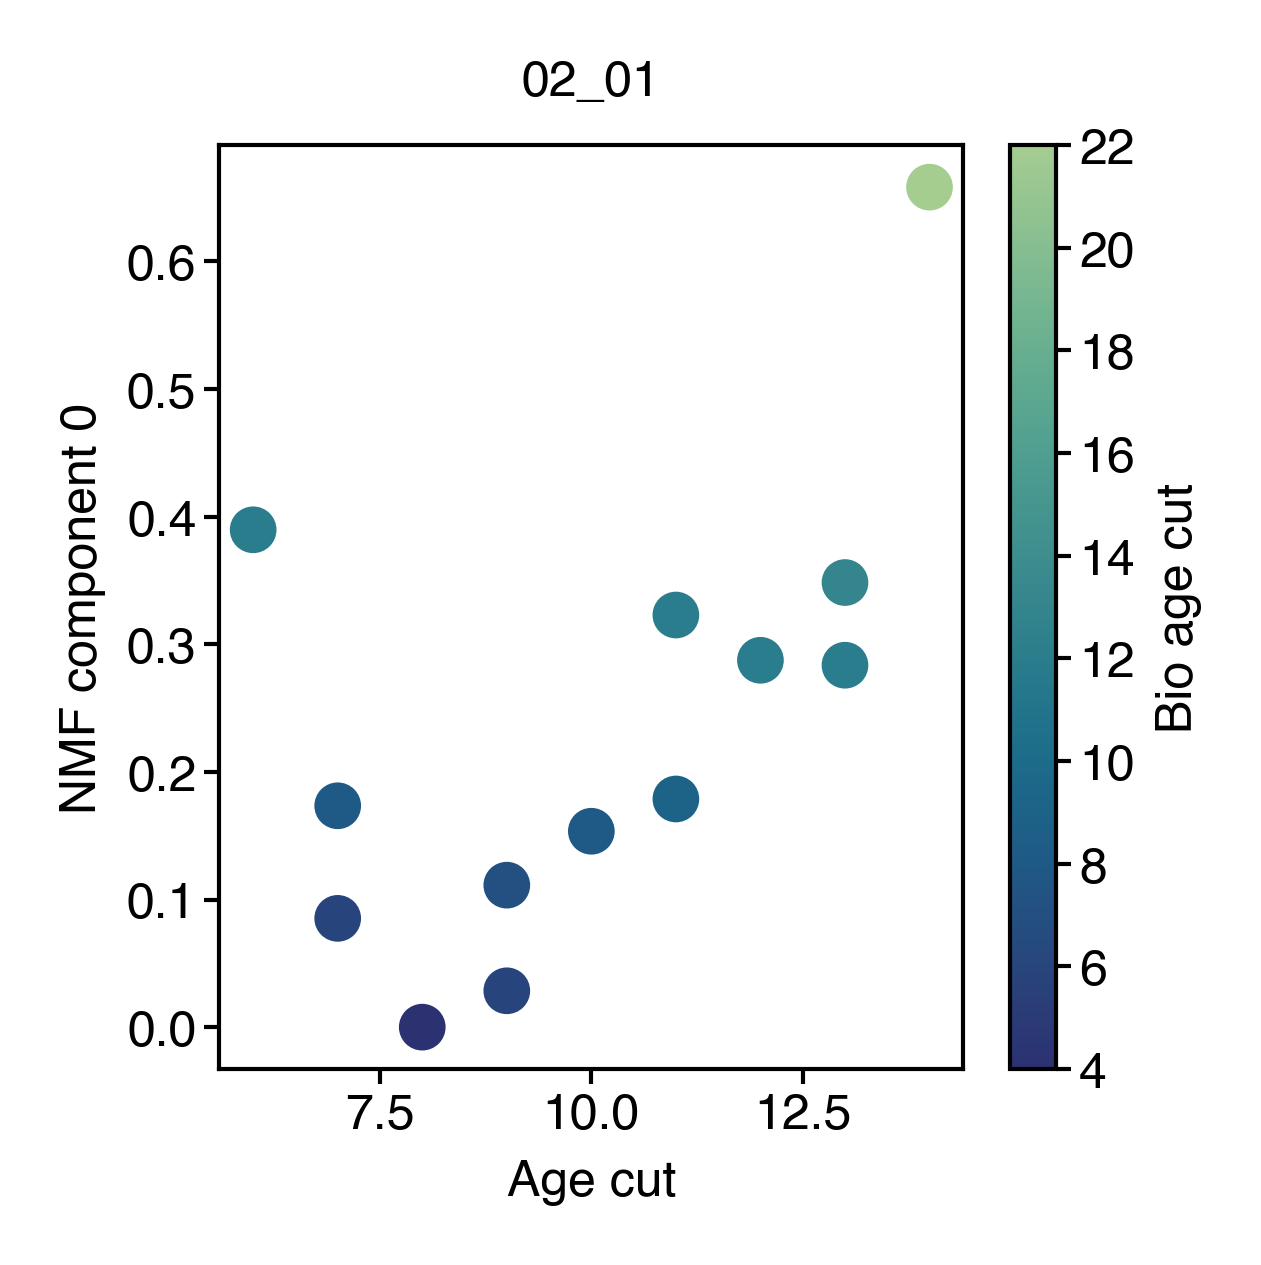

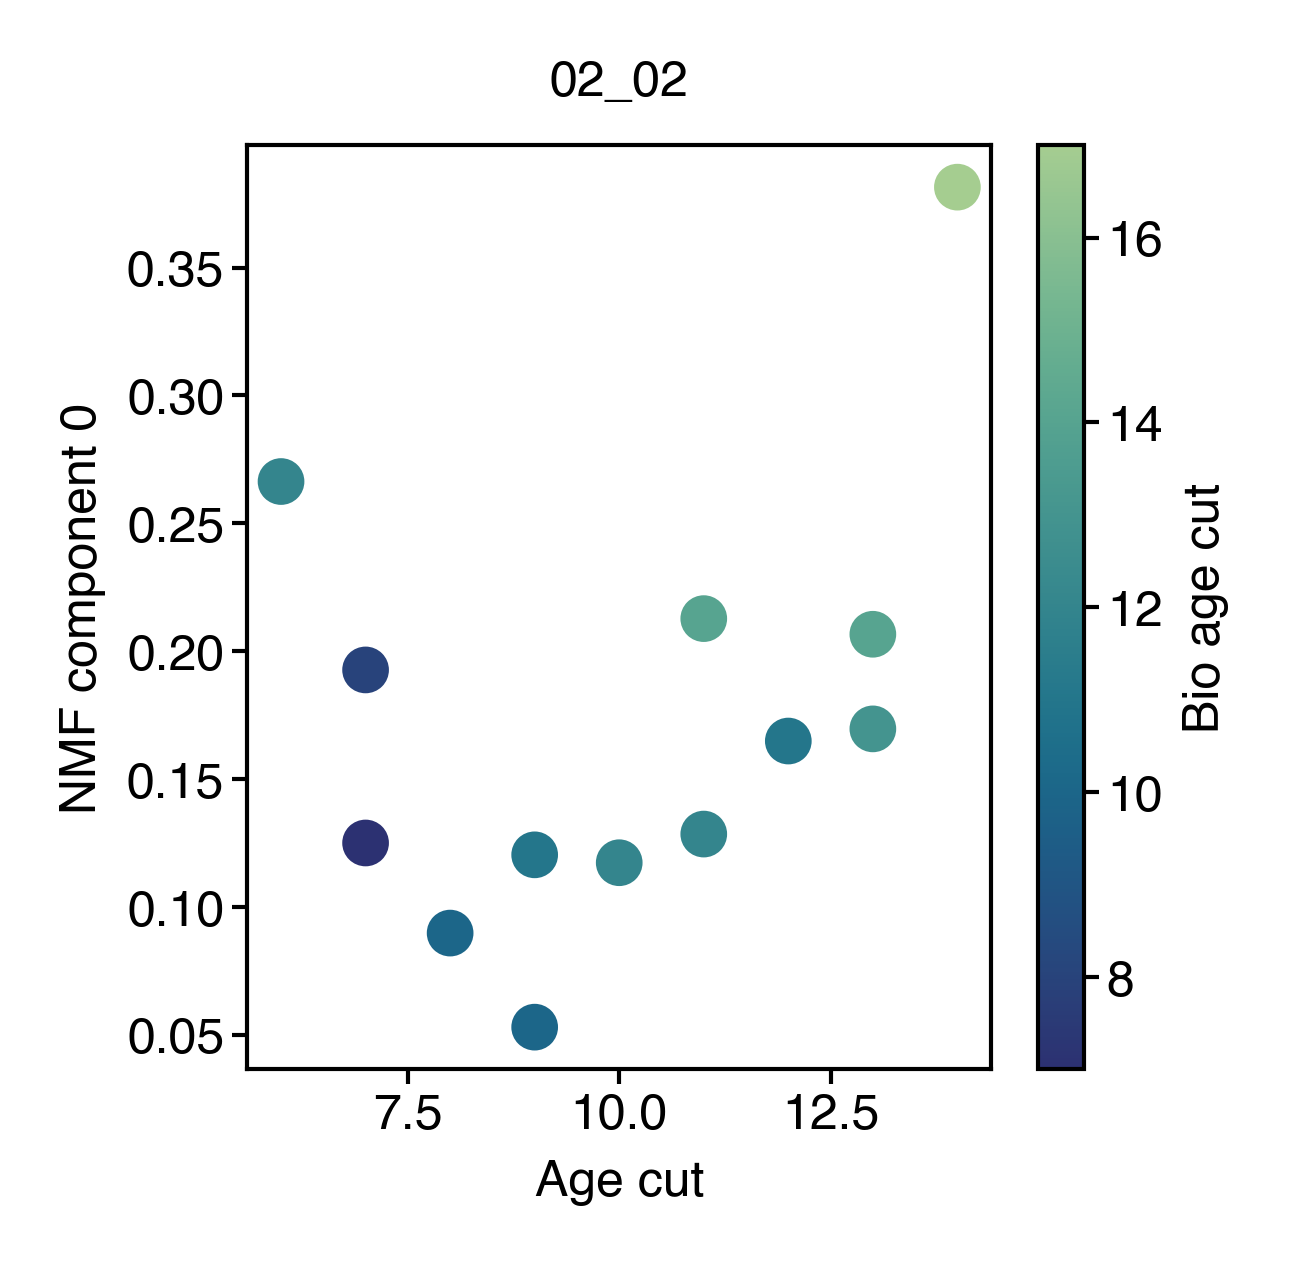

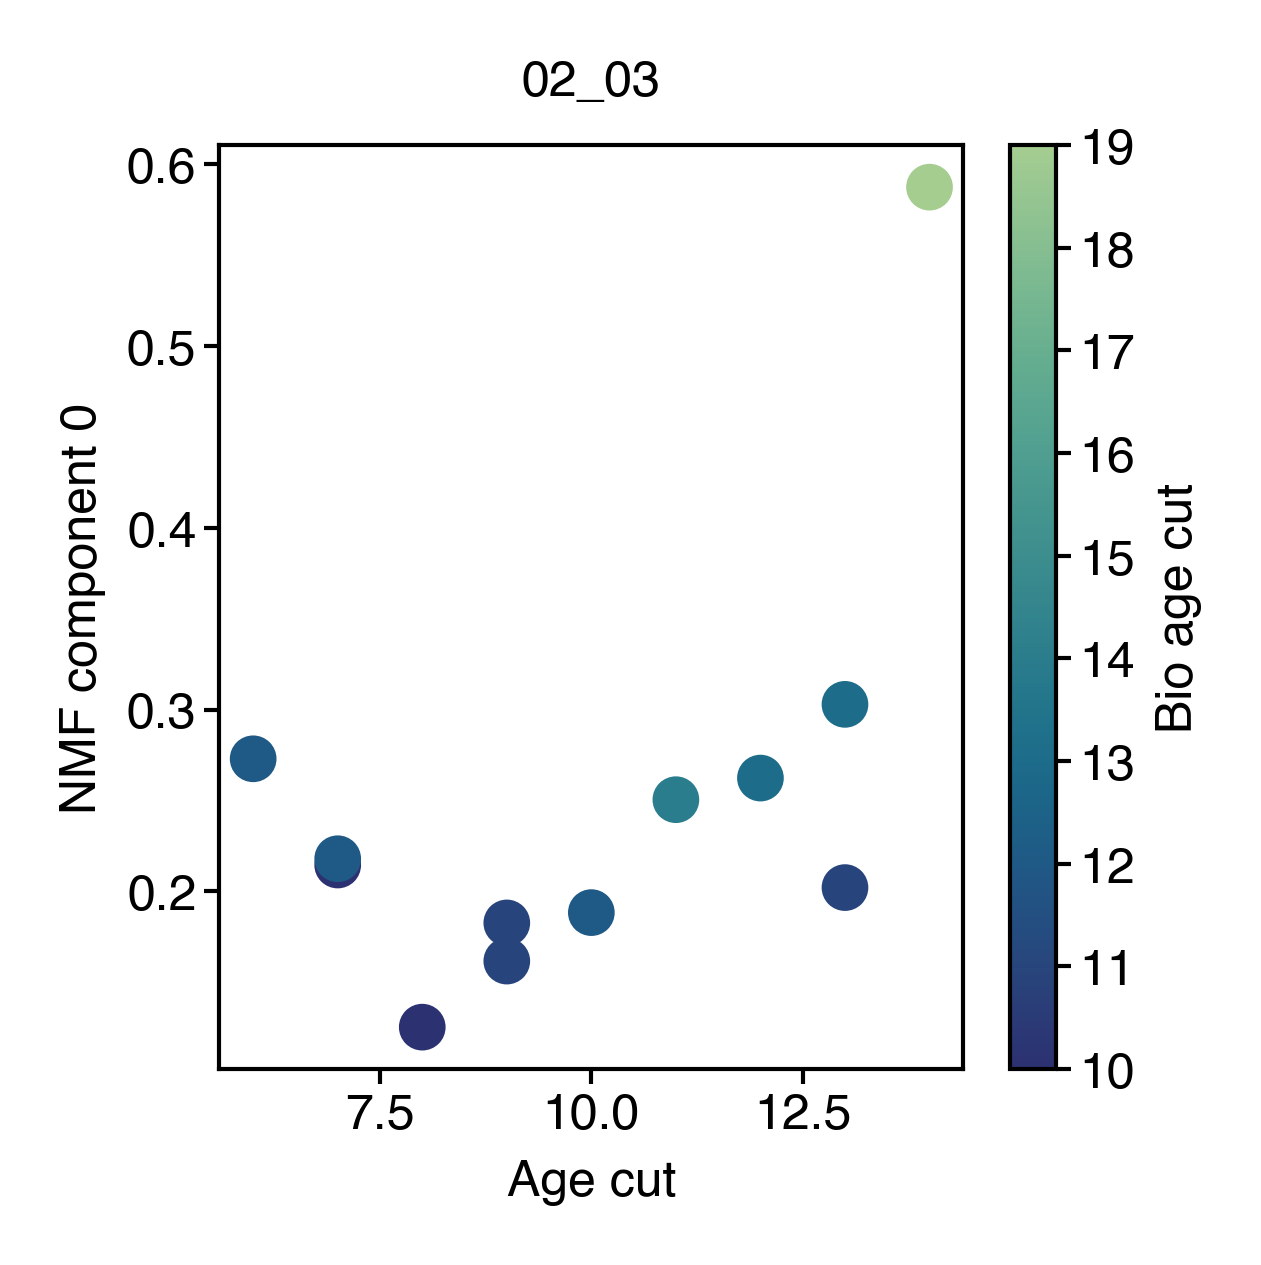

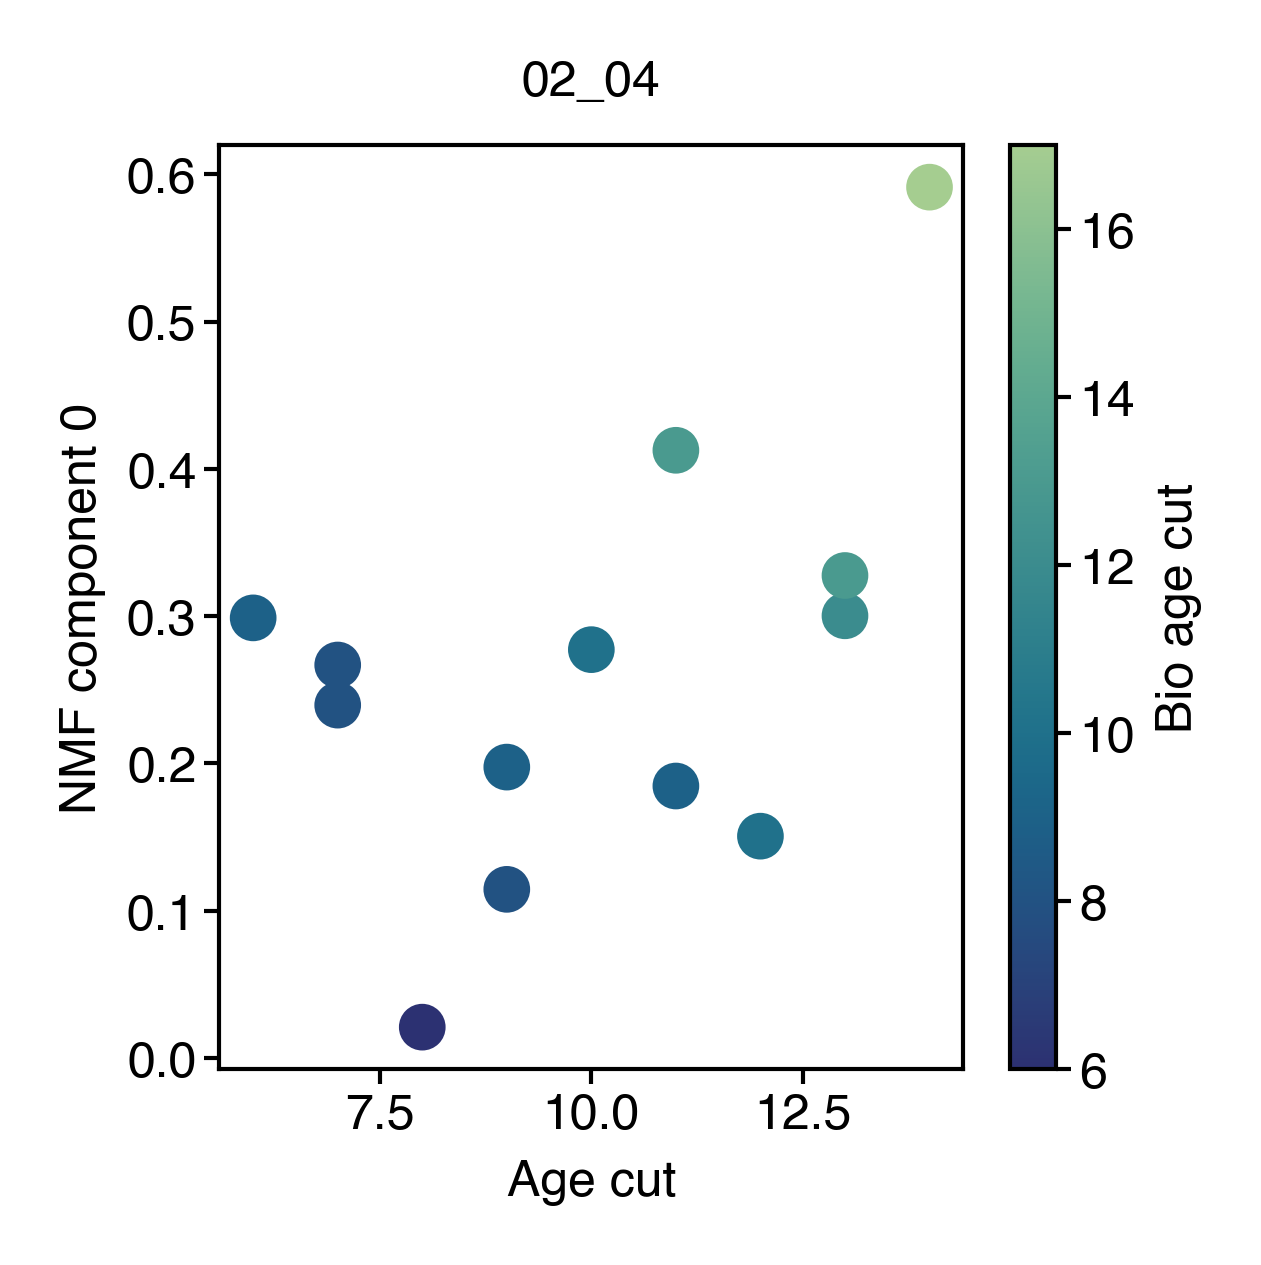

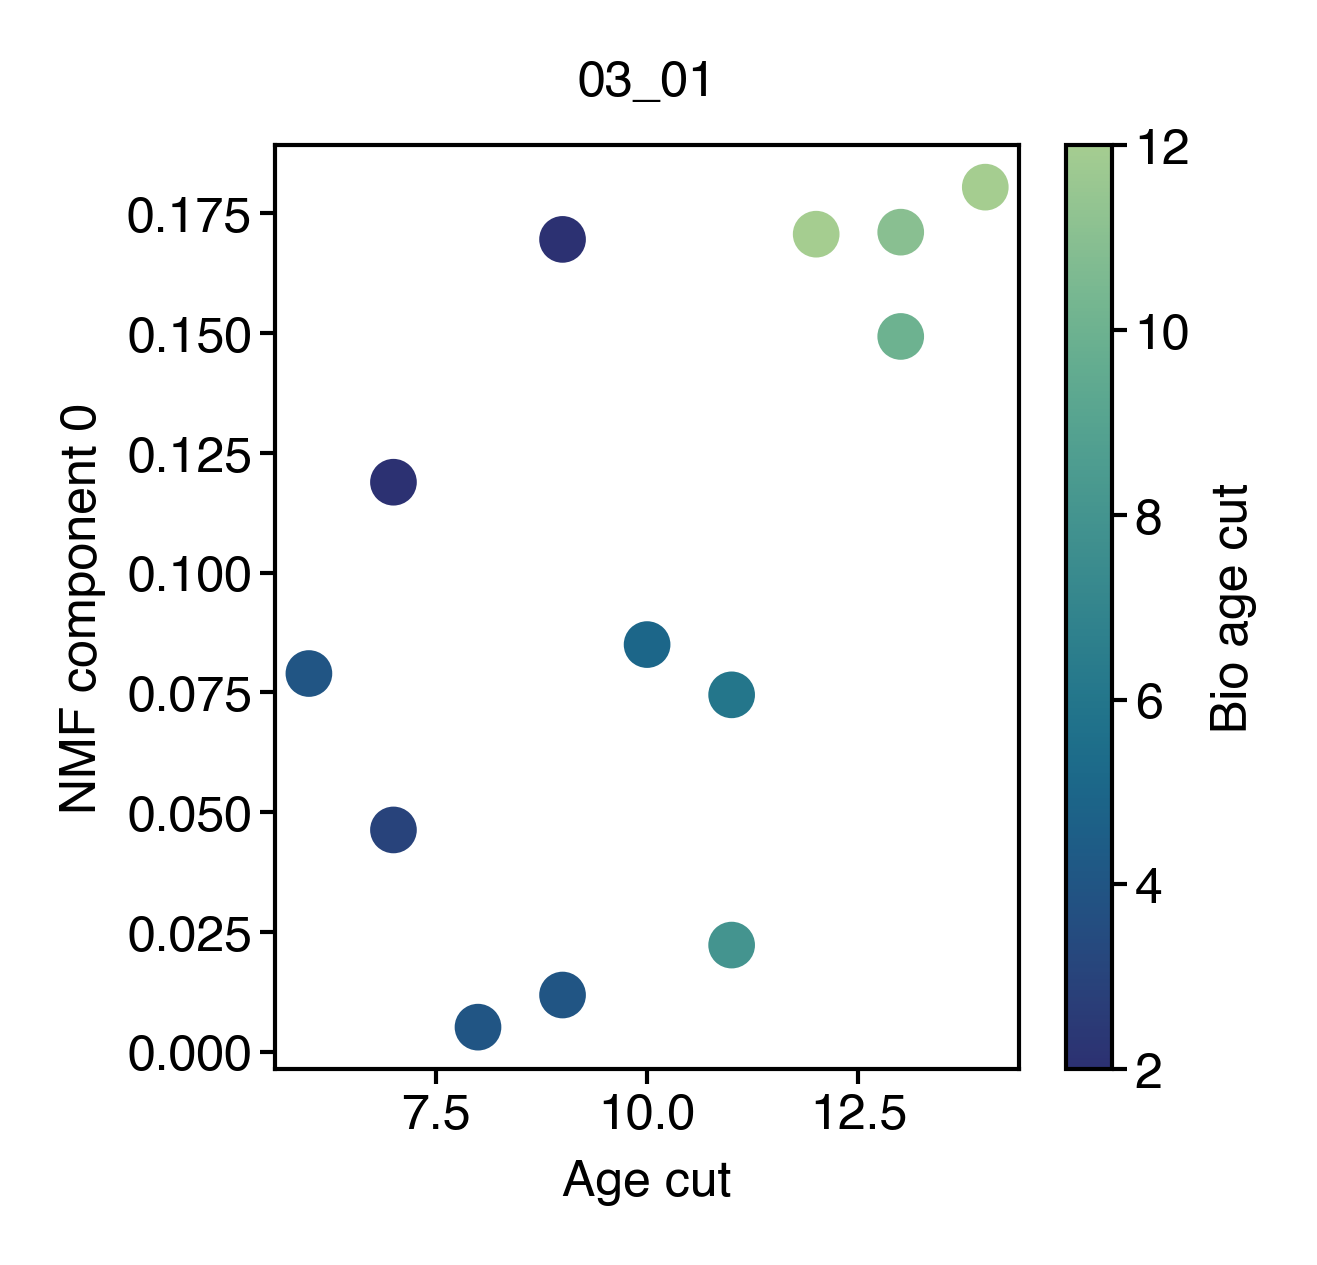

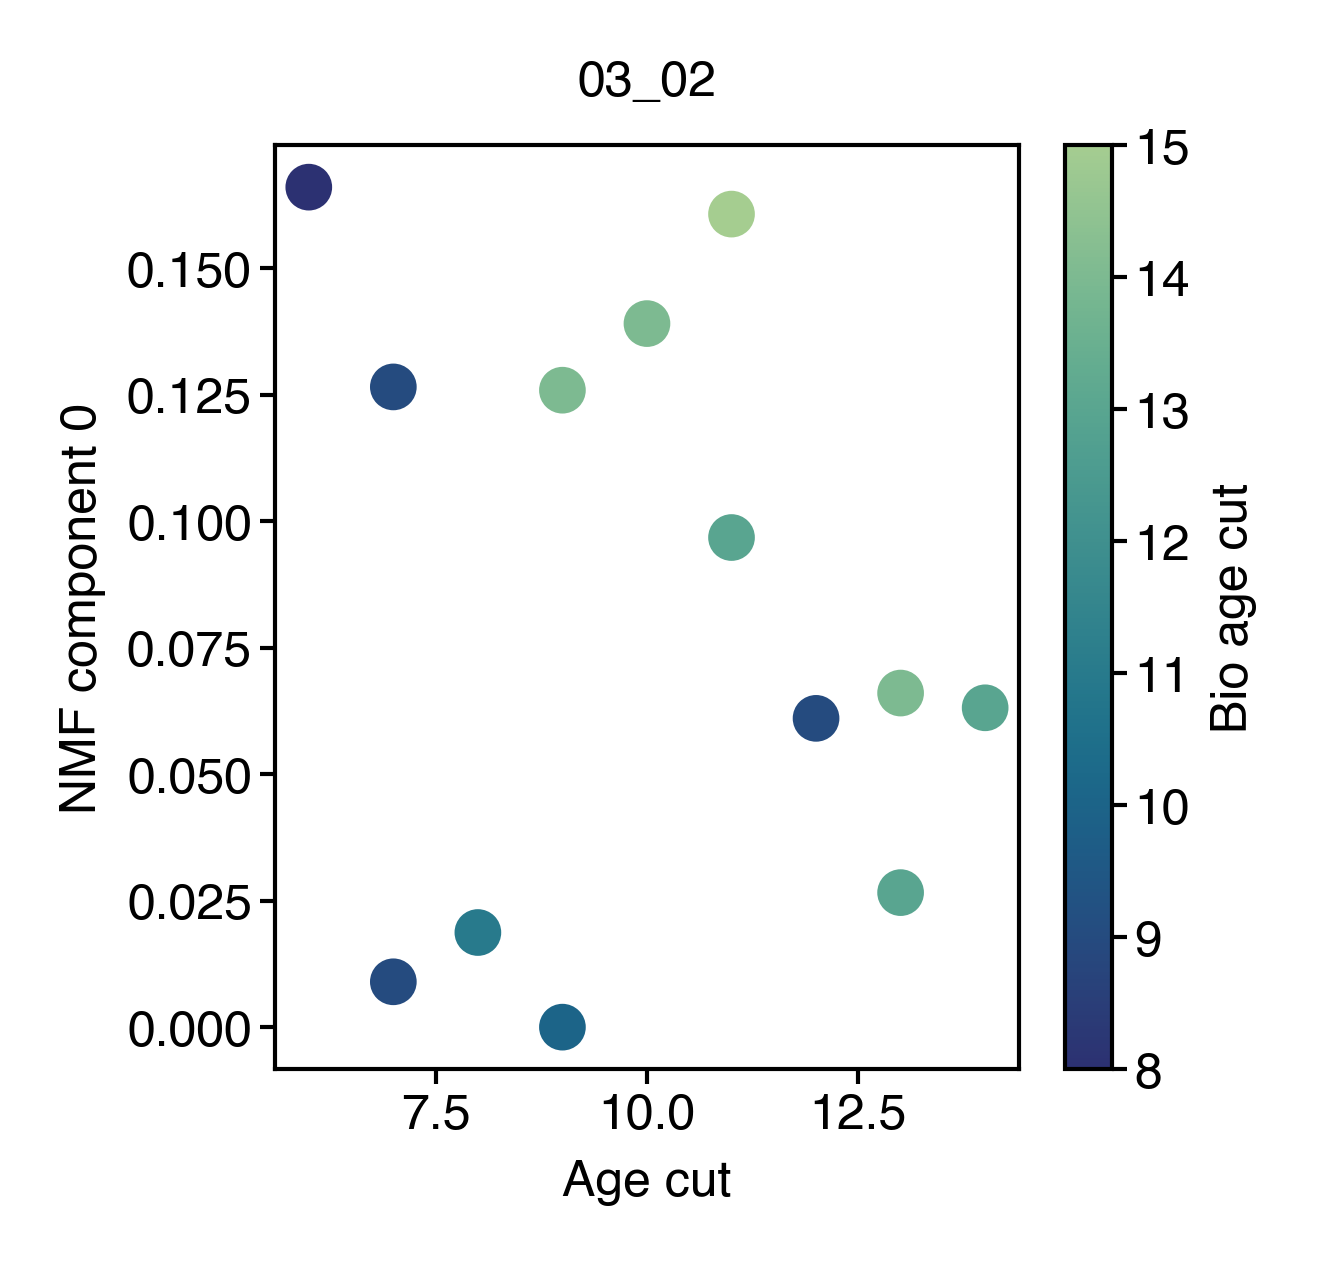

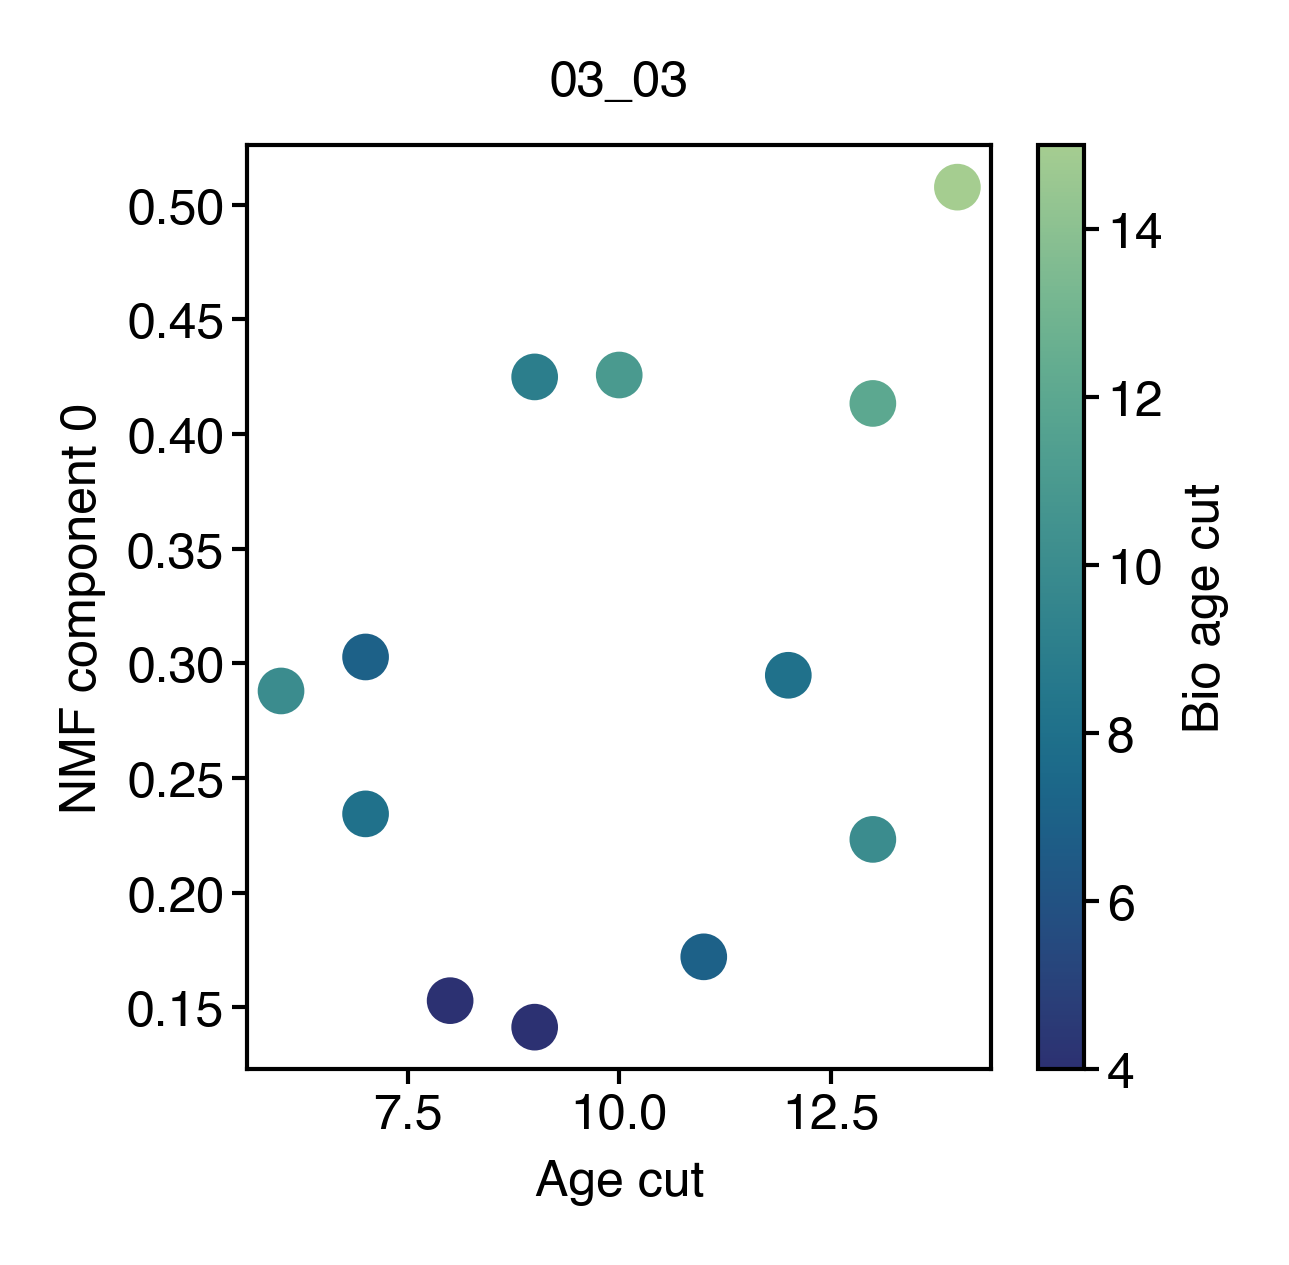

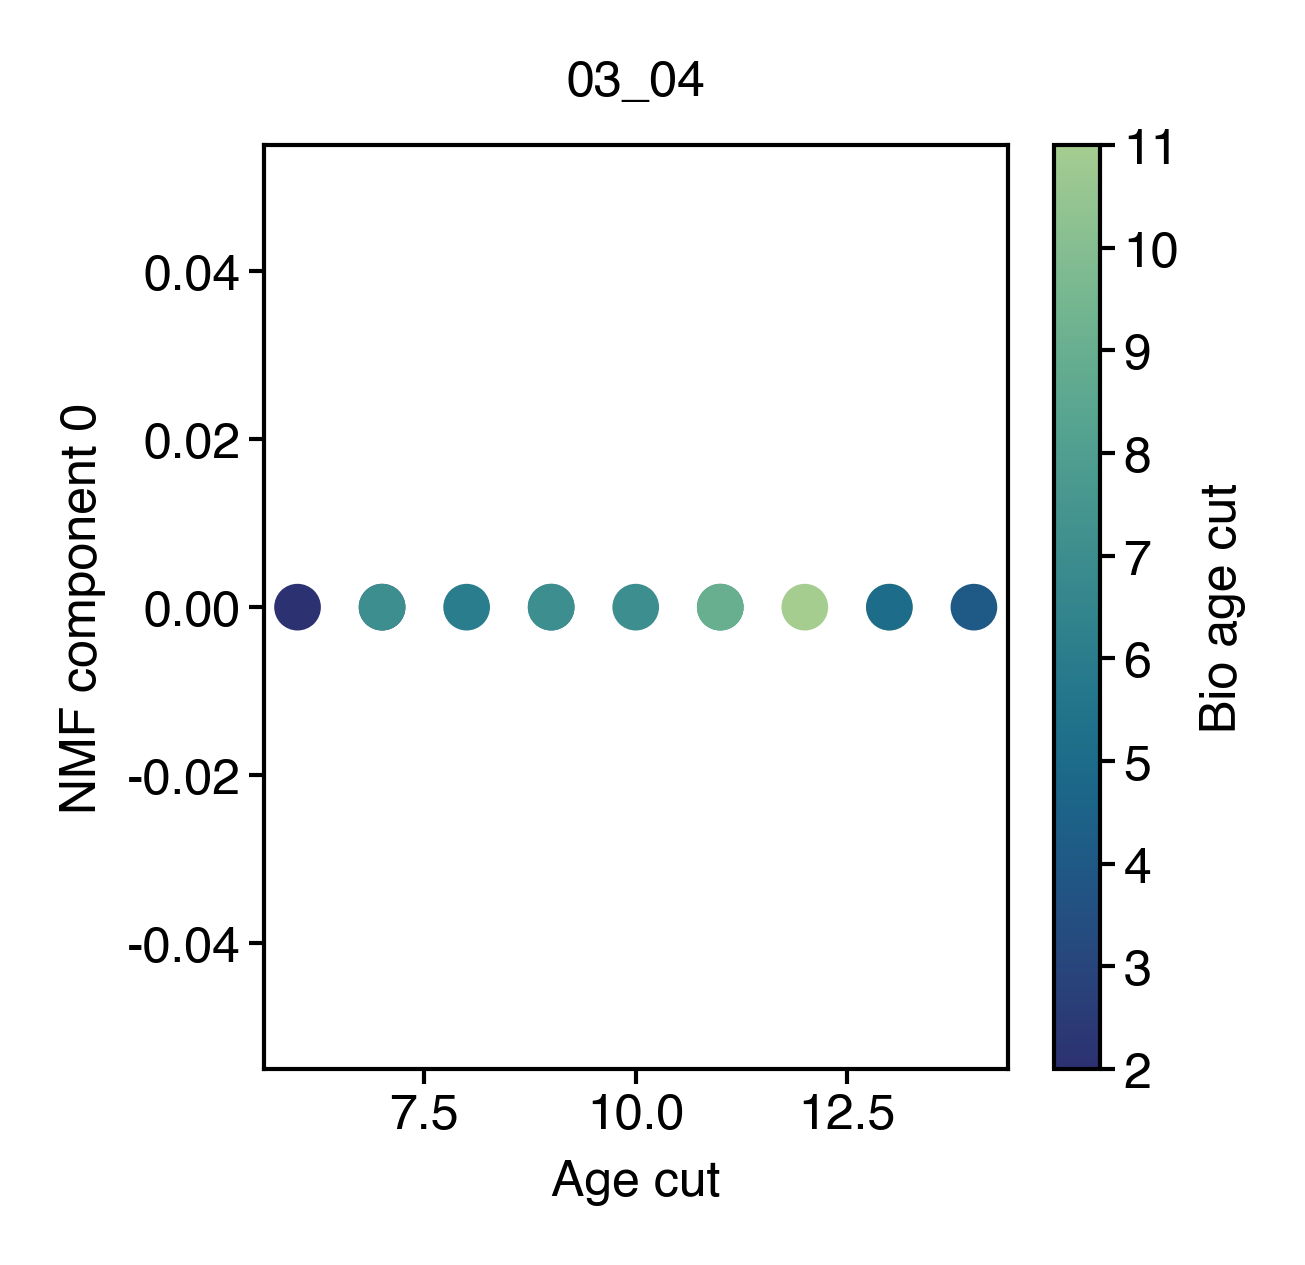

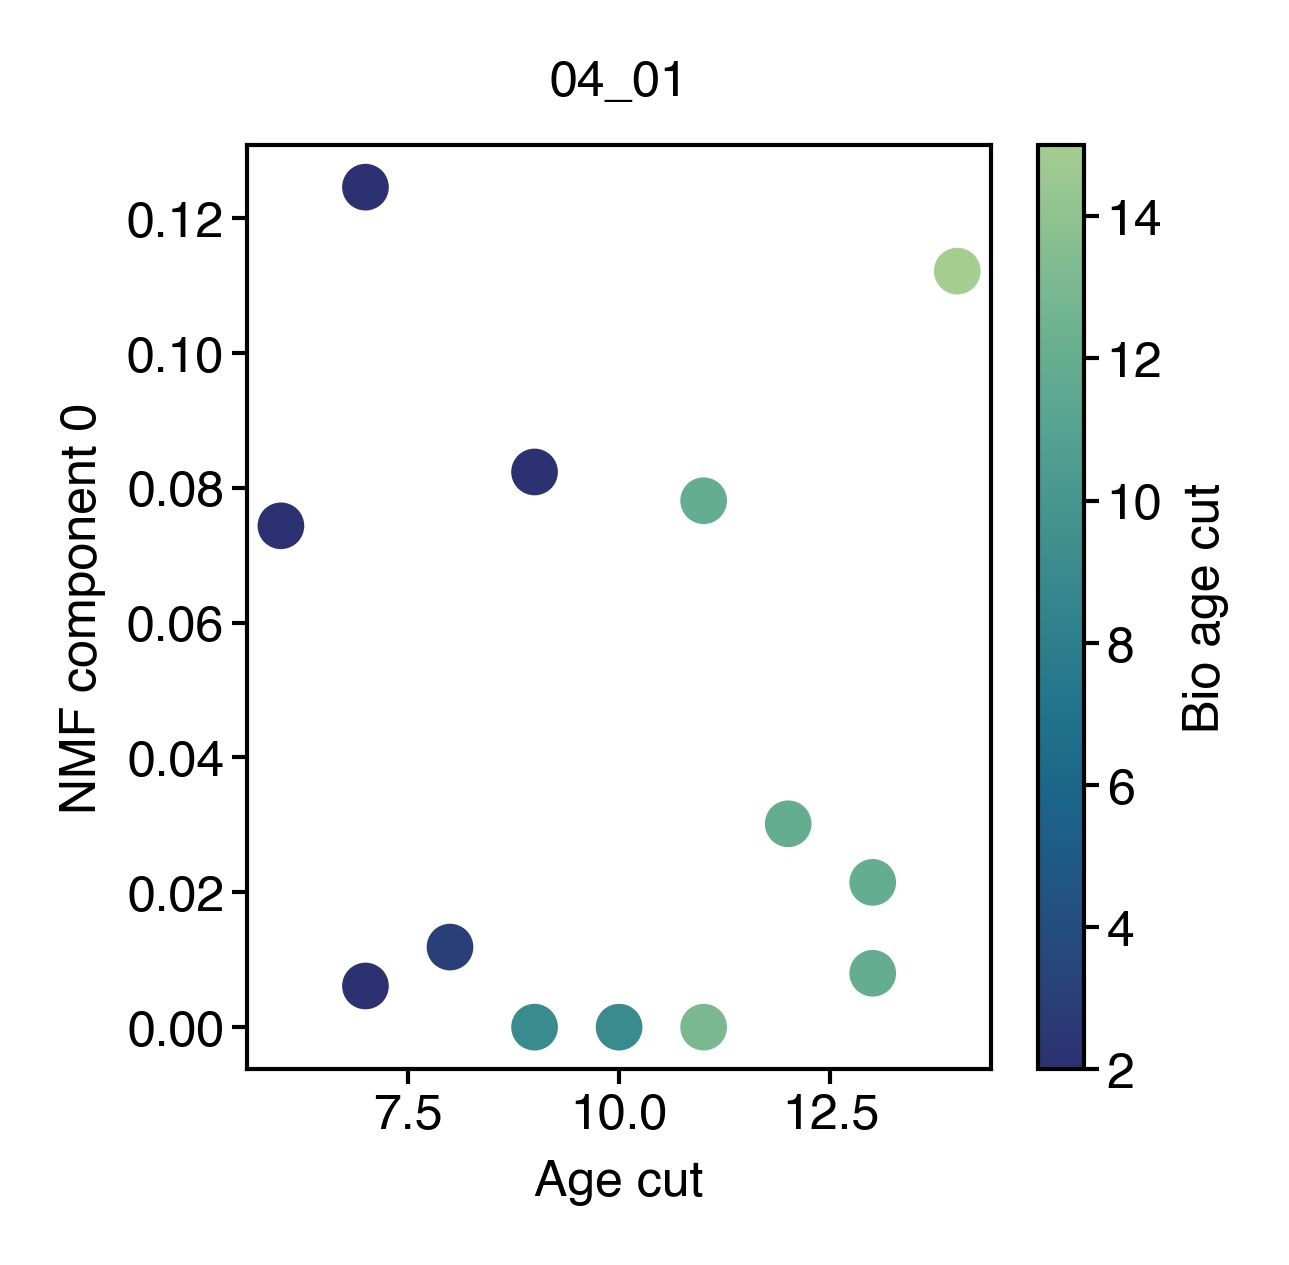

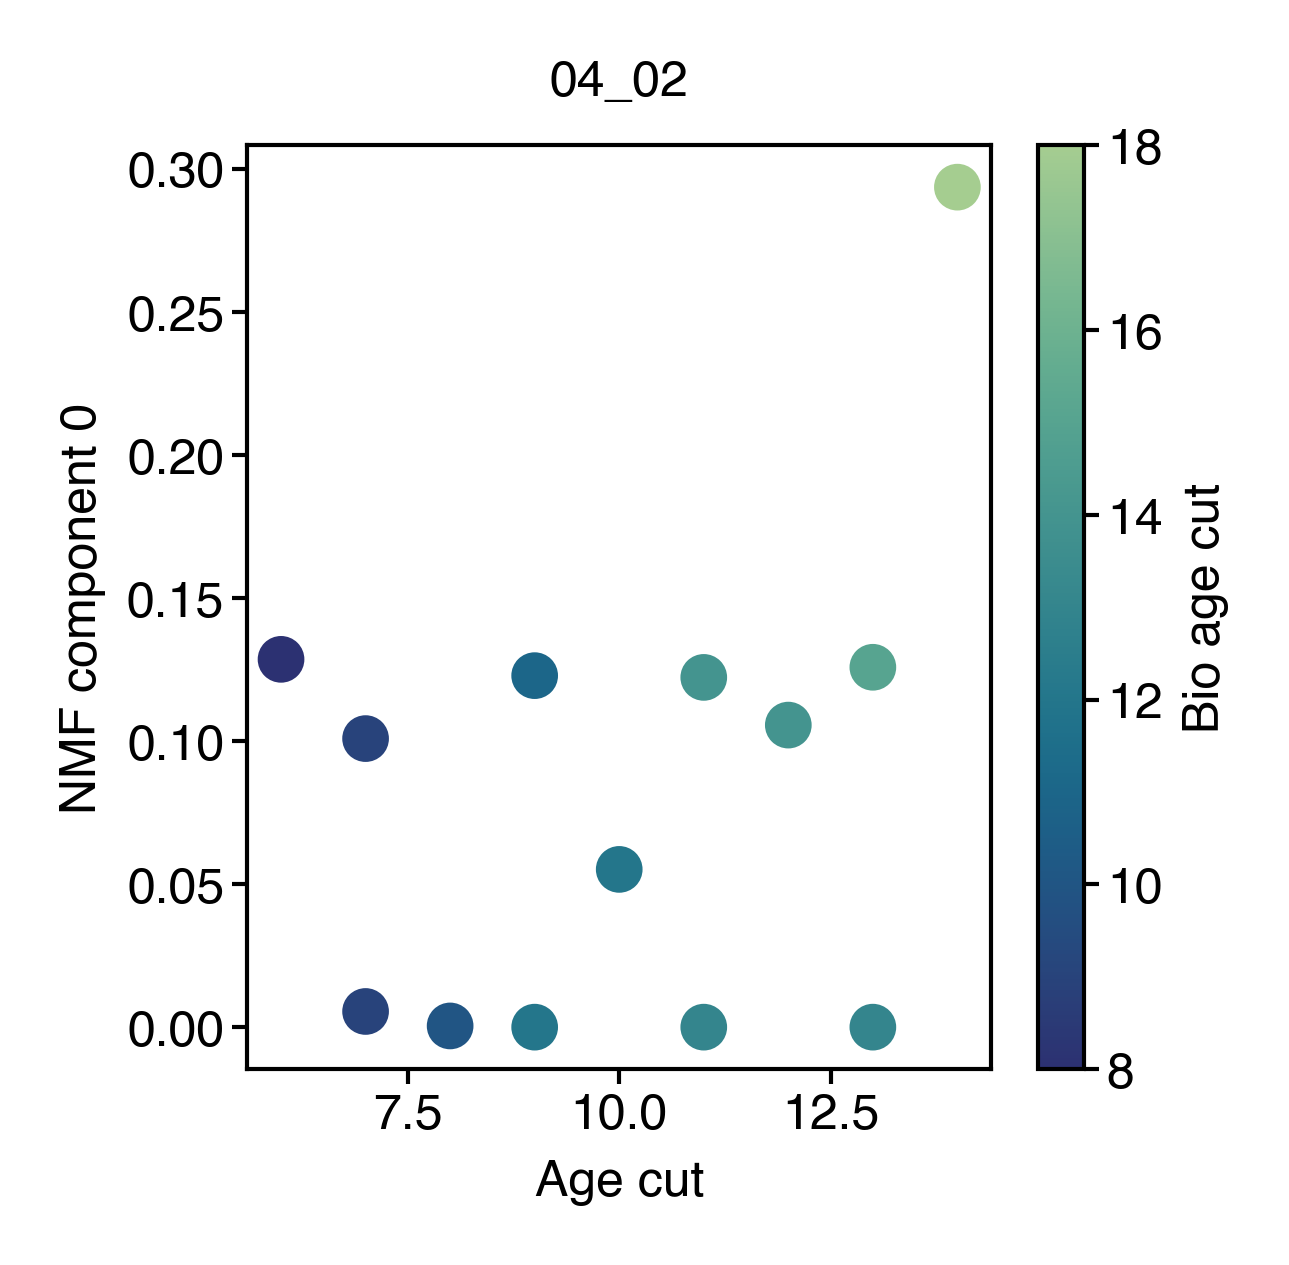

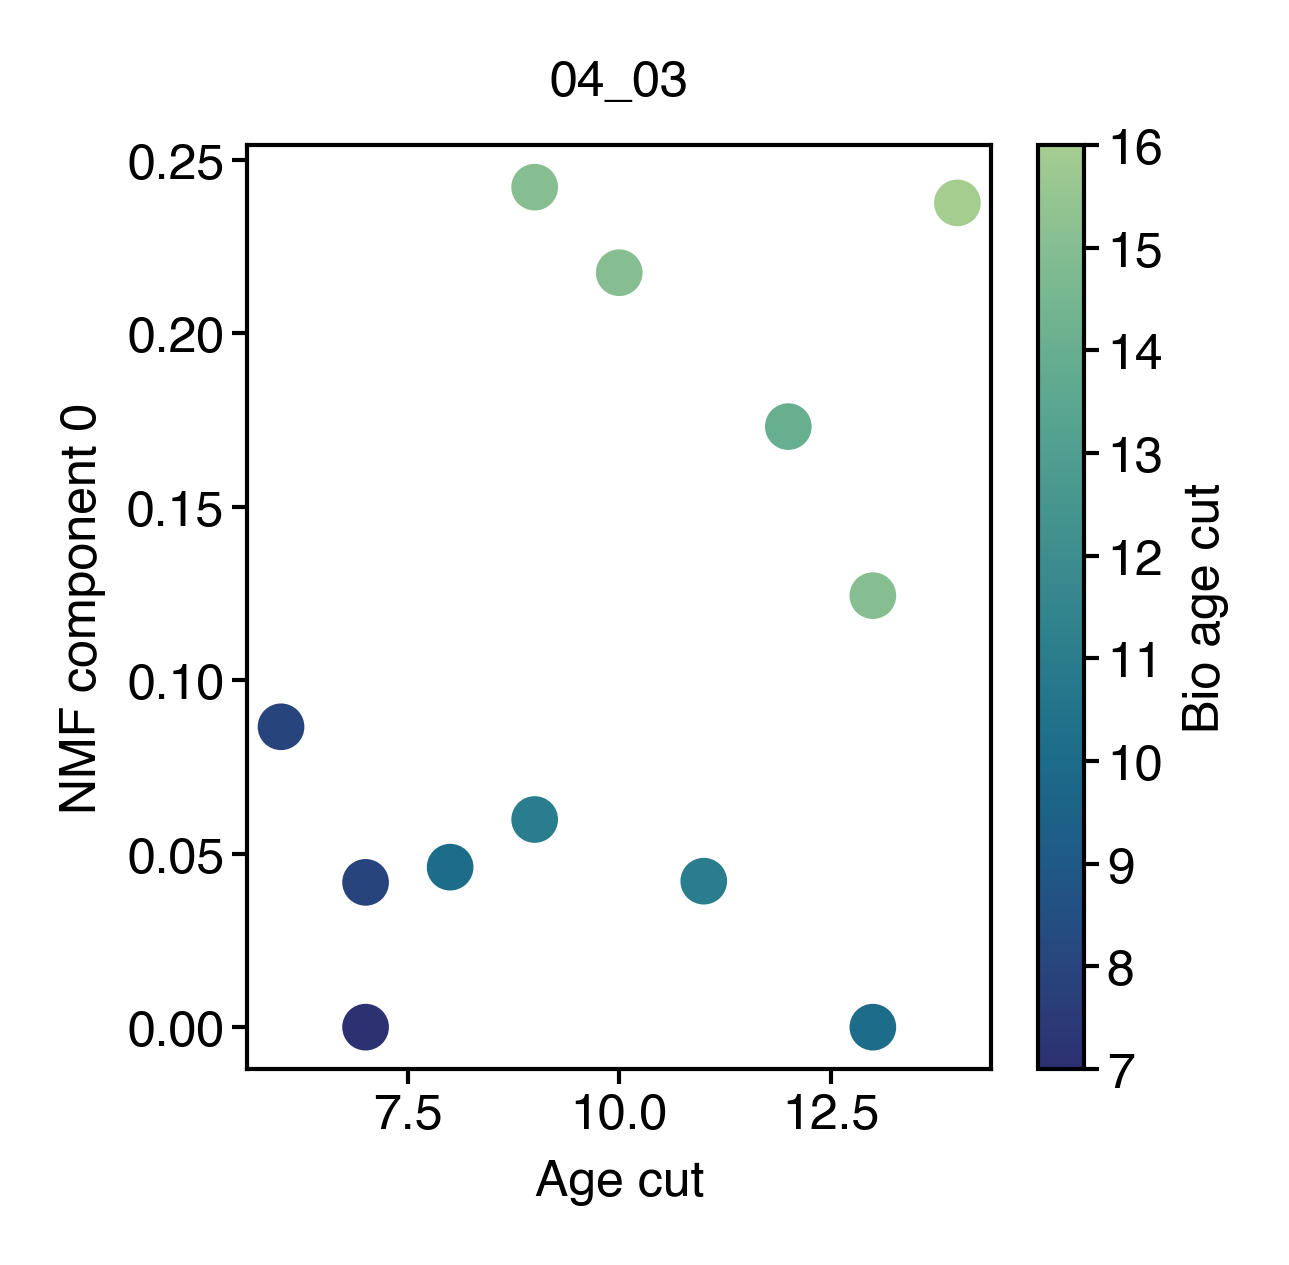

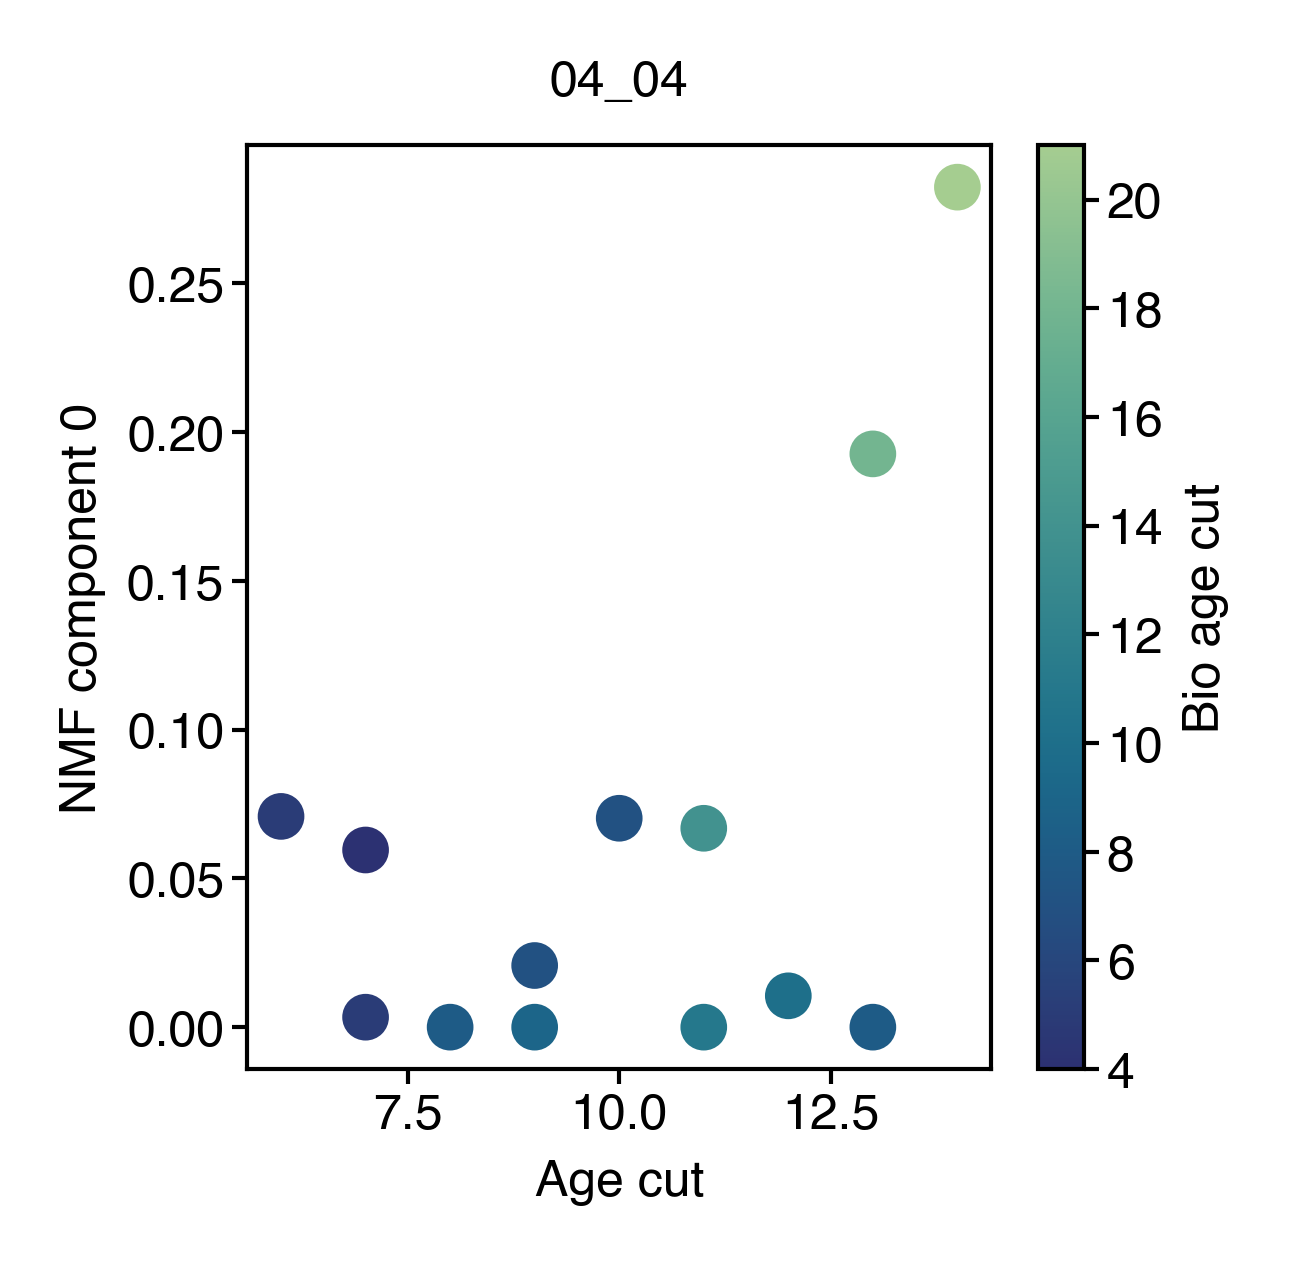

In [86]:
for mouse, _df in filt_df.groupby('mouse'):
    figure(2, 2)
    plt.scatter(_df['age_cut'], _df[0], c=_df['bio_age_cut'], cmap='crest_r')
    plt.ylabel("NMF component 0")
    plt.xlabel("Age cut")
    plt.colorbar(label='Bio age cut')
    plt.title(mouse)

In [ ]:
for mouse, _df in filt_df.groupby('mouse'):
    figure(2, 2)
    plt.scatter(_df['age_cut'], _df[3], c=_df['bio_age_cut'], cmap='crest_r')
    plt.ylabel("NMF component 3")
    plt.xlabel("Age cut")
    plt.colorbar(label='Bio age cut')
    plt.title(mouse)